In [1]:
# !pip install numpy pandas matplotlib seaborn
# !pip install scikit-learn scipy
# !pip install tqdm
# !pip install xgboost

In [2]:
import numpy as np
import sklearn
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.signal import find_peaks
from scipy.signal import lombscargle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 15 octobre (1h30) et le 22 octobre (3h).<br> 
Deadline : 29 otobre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Nom des étudiants : Mathis Pernin et Coutrot Léos

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [4]:
pdws = np.load('./radars/train/pdw-1000.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['puissance']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

<div class=consignes> et les fichiers d'annotations:</div>

In [5]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

with open('./radars/test_labels.json') as f: 
    test_dict_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

# Table of Contents
1. [Data Loading](#Data-Loading)
2. [First Exploratory Analysis](#First-Exploratory-Analysis)
3. [Baseline model](#Baseline-Model)
4. [Deep Data Analysis](#Deep-Data-Analysis)
5. [Model Training](#Model-Training)
6. [Feature Selection](#Feature-Selection)
7. [Final Model Training](#Final-Model-Training)
8. [Conclusion](#conclusion)



# Data Loading

In [6]:
print(pdws.files)

['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi']


In [7]:
# construire un fichier train_data avec les pdw dans 6 colonnes et un label menace/nonmenace (0/1)
train_data = []
for i in tqdm(range(len(dict_labels)), total=len(dict_labels), desc="Processing PDWs"):
    pdw = np.load(f'./radars/train/pdw-{i}.npz')
    label = 1 if dict_labels[f'pdw-{i}'] == 'menace' else 0
    row = [
        pdw['date'],
        pdw['largeur'],
        pdw['frequence'],
        pdw['puissance'],
        pdw['theta'],
        pdw['phi'],
        label
    ]
    train_data.append(row)
    
train_data = pd.DataFrame(train_data, columns=['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi', 'label'])

# construire un fichier test_data avec les pdw dans 6 colonnes et un label menace/nonmenace (0/1)
test_data = []
for i in tqdm(range(len(test_dict_labels)), total=len(test_dict_labels), desc="Processing PDWs"):
    pdw = np.load(f'./radars/test/pdw-{i}.npz')
    label = 1 if test_dict_labels.get(f'pdw-{i}', 'nonmenace') == 'menace' else 0
    row = [
        pdw['date'],
        pdw['largeur'],
        pdw['frequence'],
        pdw['puissance'],
        pdw['theta'],
        pdw['phi'],
        label
    ]
    test_data.append(row)

test_data = pd.DataFrame(test_data, columns=['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi', 'label'])

Processing PDWs: 100%|██████████| 800/800 [00:01<00:00, 628.58it/s]


In [8]:
print(train_data['label'].value_counts())

label
0    1011
1     989
Name: count, dtype: int64


The dataset is balanced (approximately 50% of each class in the data). Thus the accuracy will be a good metric to evaluate the model performance, as well as f1-score.

# First Exploratory Analysis

We start by plotting the signals from both classes against time to try to visualize them, understand their characteristics and identify potential structural differences between threat and non-threat signals that could help us create discriminative features for classification.

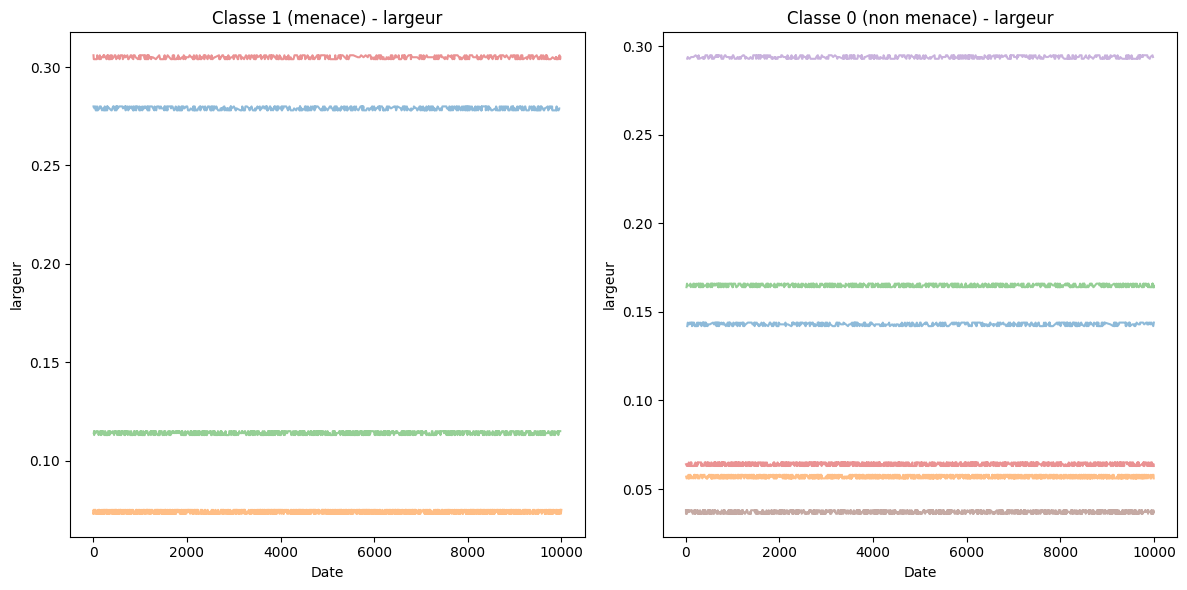

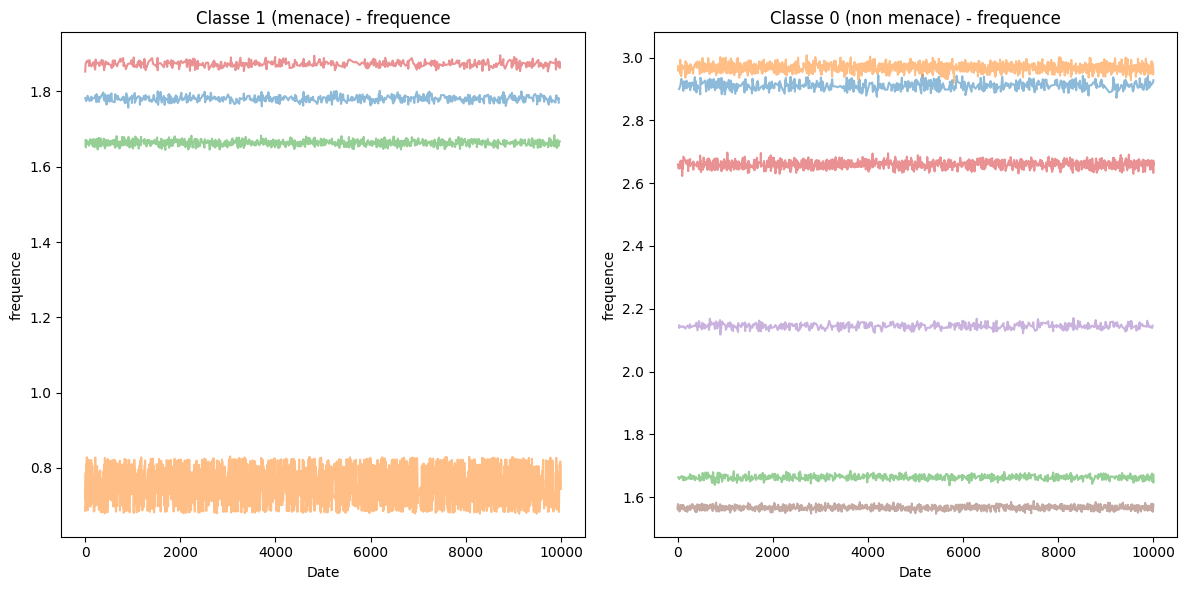

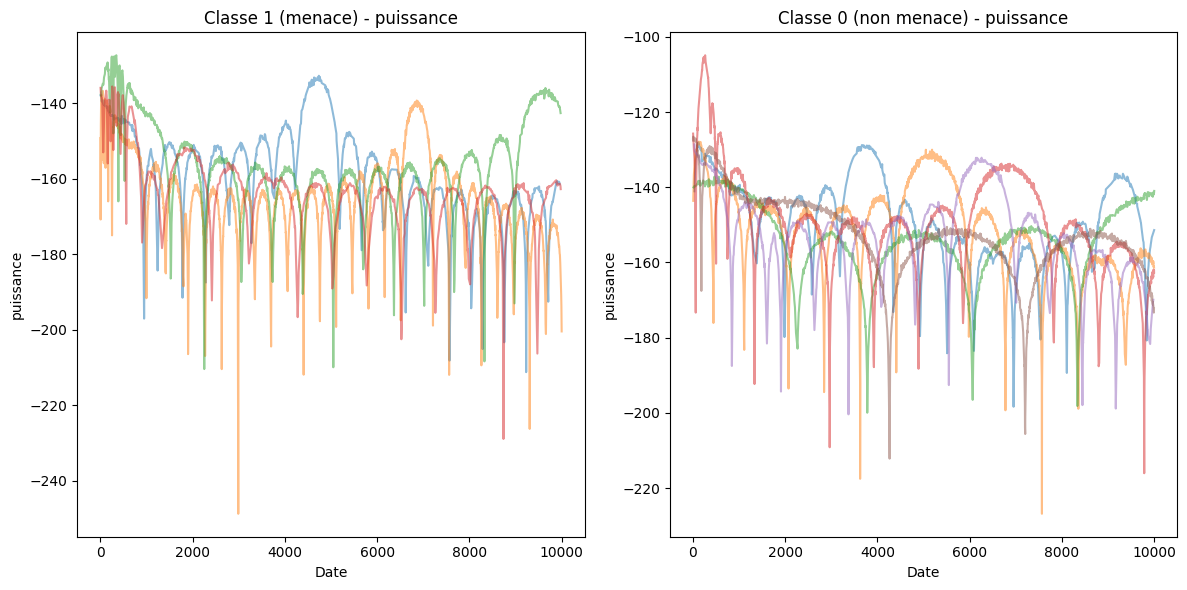

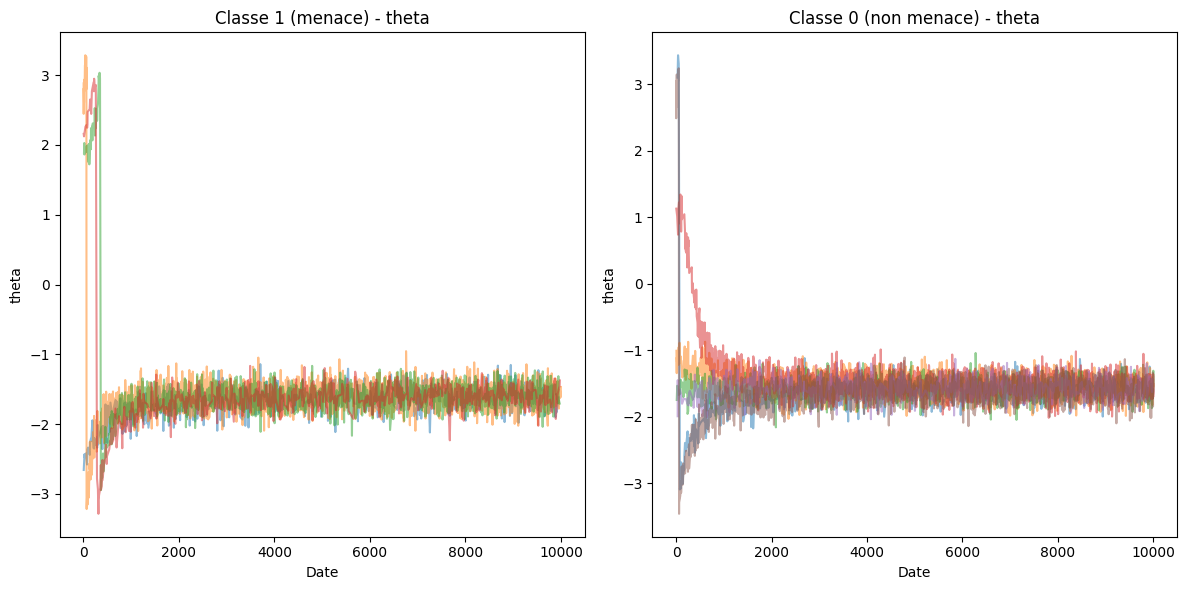

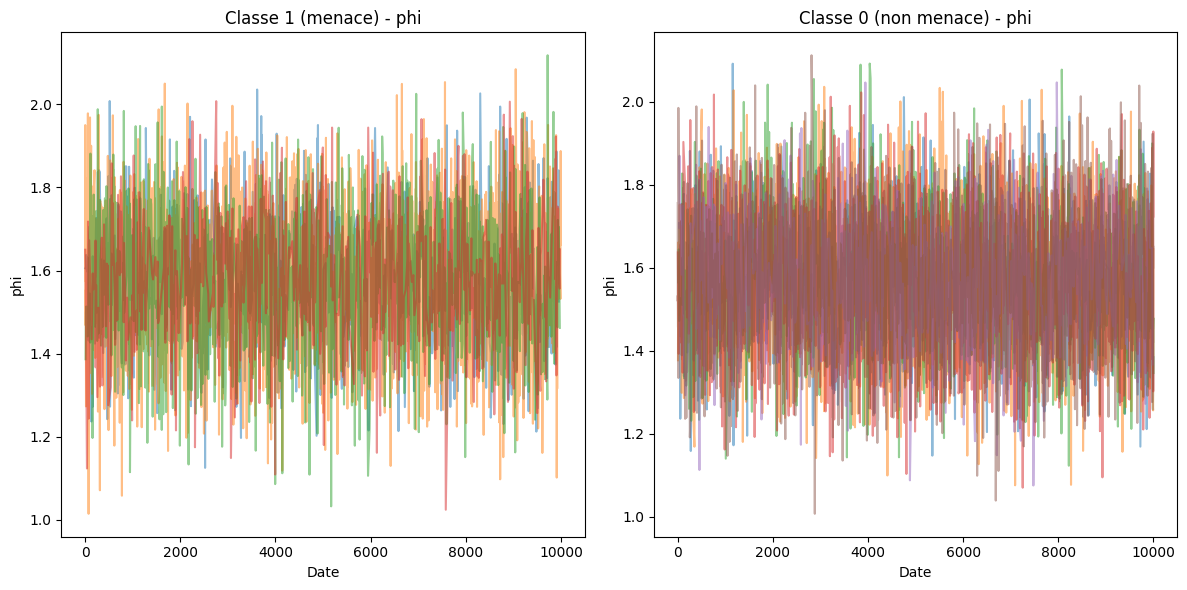

In [9]:
indices = np.random.choice(range(len(train_data)), size=10, replace=False)

for col in ['largeur', 'frequence', 'puissance', 'theta', 'phi']:
    plt.figure(figsize=(12, 6))
    
    # Classe 1 (menace)
    plt.subplot(1, 2, 1)
    for i in indices:
        if train_data.iloc[i]['label'] == 1:
            plt.plot(train_data.iloc[i]['date'], train_data.iloc[i][col], alpha=0.5)
    plt.title(f'Classe 1 (menace) - {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    
    # Classe 0 (non menace)
    plt.subplot(1, 2, 2)
    for i in indices:
        if train_data.iloc[i]['label'] == 0:
            plt.plot(train_data.iloc[i]['date'], train_data.iloc[i][col], alpha=0.5)
    plt.title(f'Classe 0 (non menace) - {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    
    plt.tight_layout()
    plt.show()
    

From the impulsion plot, we can observe that the impulsion width of the signal is quite similar across the 2 classes. Regarding the frequence plot, it seems that the amplitude of the frequence signal is significantly higher for some threat signals compared to non-threat ones. This could be a useful feature for classification. Yet some threat signals have similar amplitude as non-threat ones, so this feature won't enable us to discriminate all threat signals. The power plot indicates that the power signals is quite specific and characetistic of the signal (presence or absence of peaks, frequence of peaks, height/width of peaks, etc.). Although we can't identify a property of the signal that would discriminate between the classes yet, it still contains a lot of information that could be further exploited for classification. The angular plot (theta and phi) seems to be noisy and not very informative for classification (at least difficult to exploit).

# Baseline Model

To identify our first features, we simply compute the basic statistical properties of the different PDW components (mean, std, min, max, median) and try to evaluate their correlation with the target label.

Extracting Features: 100%|██████████| 2000/2000 [00:01<00:00, 1833.31it/s]


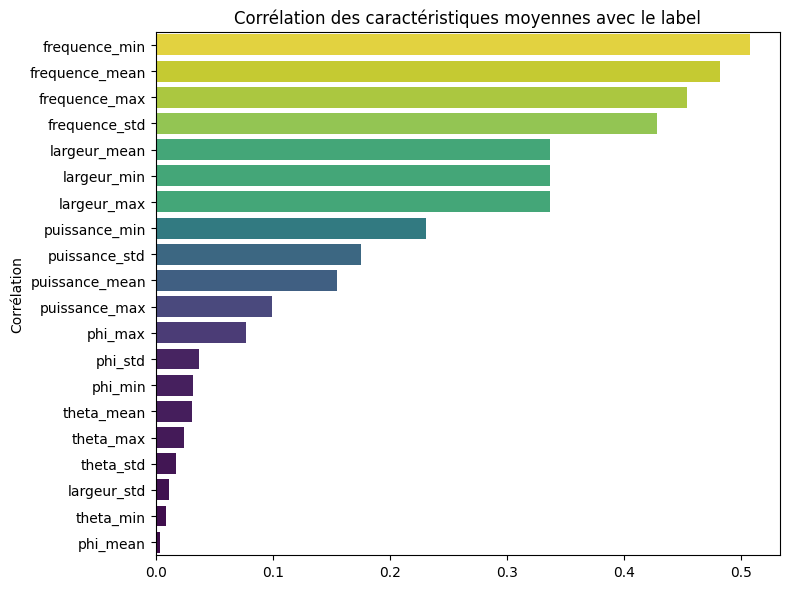

In [10]:
mean_features = []
for i in tqdm(range(len(train_data)), total=len(train_data), desc="Extracting Features"):
    features = {}
    for col in ['largeur', 'frequence', 'puissance', 'theta', 'phi']:
        data = train_data.iloc[i][col]
        features[f'{col}_mean'] = np.mean(data)
        features[f'{col}_std'] = np.std(data)
        features[f'{col}_min'] = np.min(data)
        features[f'{col}_max'] = np.max(data)
    features['label'] = train_data.iloc[i]['label']
    mean_features.append(features)

mean_features_df = pd.DataFrame(mean_features)
correlation_matrix = mean_features_df.drop('label', axis=1).corrwith(mean_features_df['label']).abs().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index, palette='viridis', hue=correlation_matrix.values, legend=False)
plt.title("Corrélation des caractéristiques moyennes avec le label")
plt.ylabel("Corrélation")
plt.tight_layout()
plt.show()

As identified on the frequence plot, the frequence information seems to be discriminative and thus useful for classification. This indicates that we could design a basic classifier only focusing on frequence-related features. We define our simple classifier by thresholding on the min frequence (that was the most correlated feature with the label). We obtain an accuracy of 0.71, which is rather good for such a simple architecture only based on one feature. This confirms that the frequence information is indeed useful for classification. Yet this simple classifier is not able to exploit the other features that could also contain useful information (e.g. power). Thus we will now try to use a more sophisticated model that can exploit all features.

In [11]:
class SimpleThresholdModel:
    def __init__(self, threshold):
        self.threshold = threshold

    def predict(self, data):
        predictions = []
        for i in range(len(data)):
            freq_min = np.min(data.iloc[i]['frequence'])
            prediction = 1 if freq_min < self.threshold else 0
            predictions.append(prediction)
        return np.array(predictions)

# Tuning the threshold
best_threshold = None
best_accuracy = 0
for threshold in np.linspace(np.min(mean_features_df['frequence_min']), np.max(mean_features_df['frequence_min']), 100):
    model = SimpleThresholdModel(threshold)
    predictions = model.predict(train_data)
    accuracy = np.mean(predictions == train_data['label'].values)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
print(f"Best threshold: {best_threshold}, Best accuracy on train data: {best_accuracy}")

# Evaluate on test data
model = SimpleThresholdModel(best_threshold)
test_predictions = model.predict(test_data)
test_accuracy = np.mean(test_predictions == test_data['label'].values)
print(f"Accuracy on test data: {test_accuracy}")

Best threshold: 1.9406051125169506, Best accuracy on train data: 0.6975
Accuracy on test data: 0.7125


# Deep Data Analysis

Let's visualize the statistical distribution of statistical properties of PDW-components across the data, to see which quantities could be discriminative features. As mentioned before, the standard deviation of the frequence is quite discriminative. The mean value of the width and frequence seem to be as well, also power to a lesser extent. 

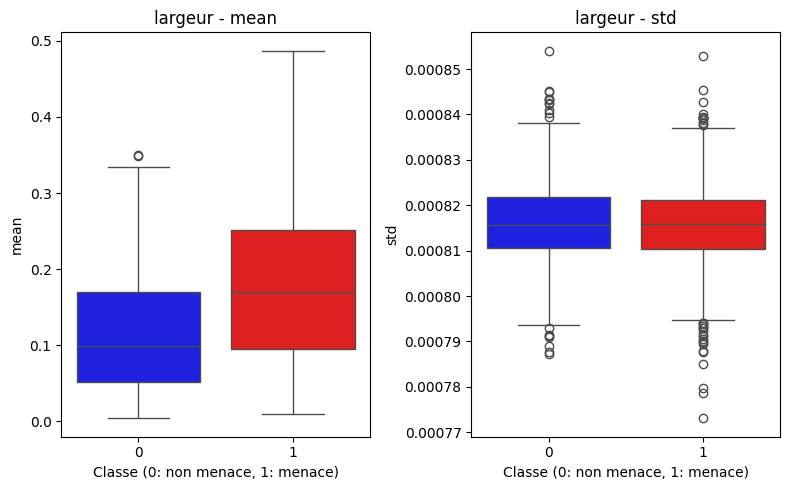

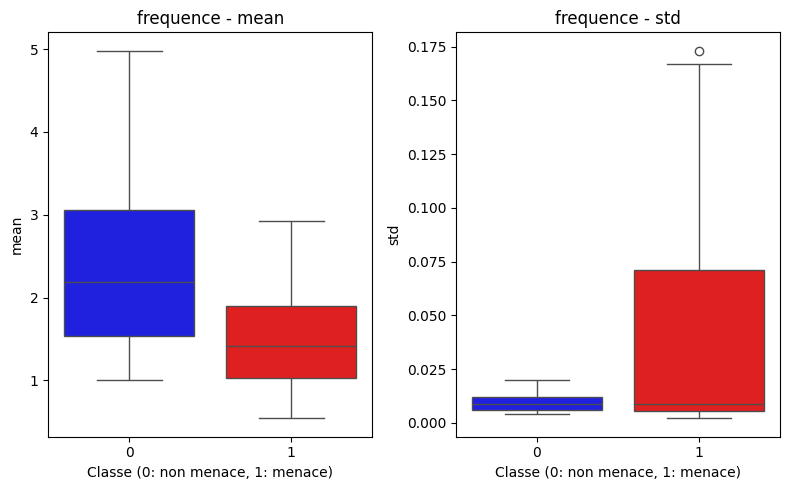

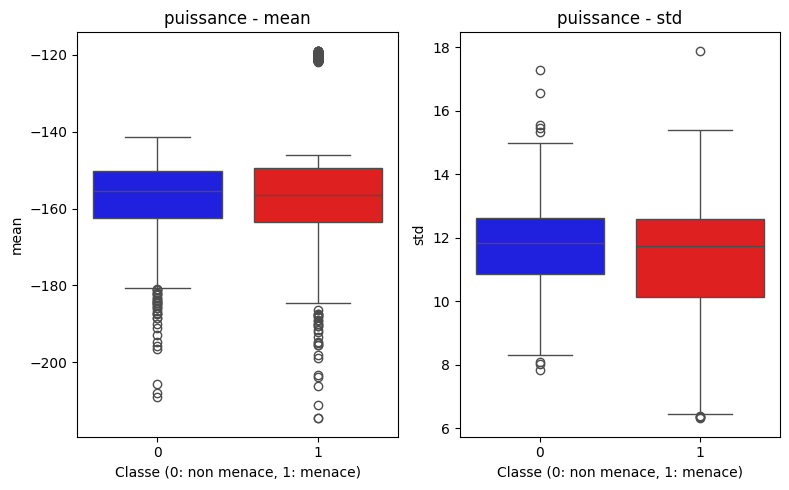

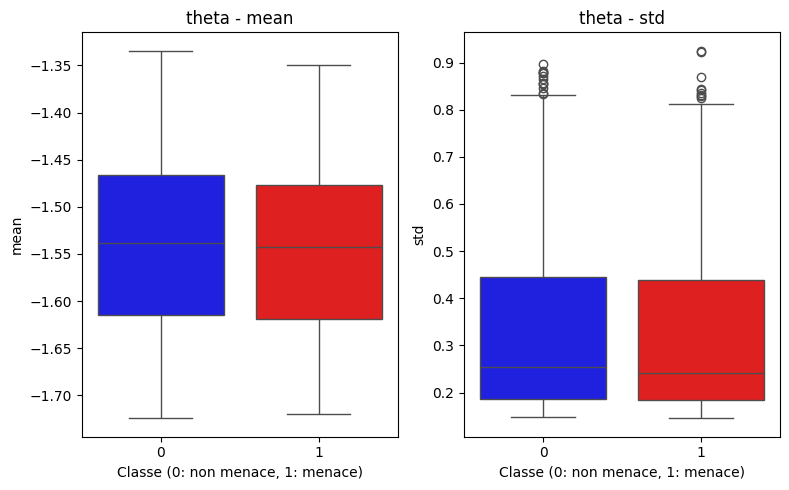

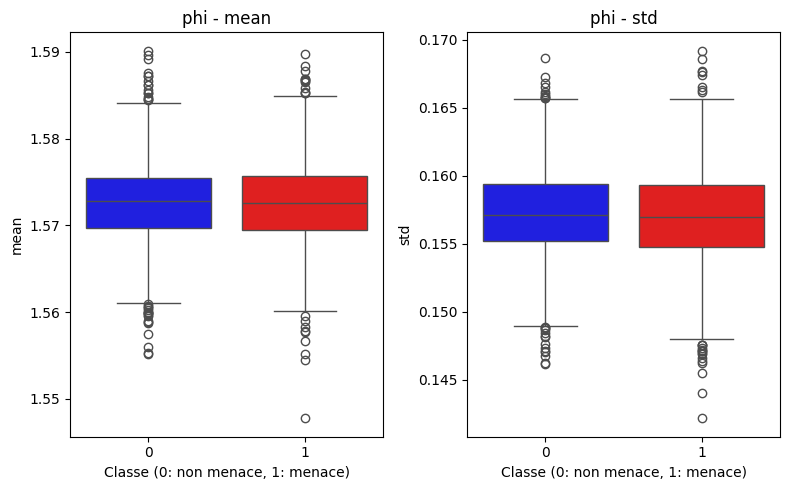

In [12]:
stats = ['mean', 'std']
columns = ['largeur', 'frequence', 'puissance', 'theta', 'phi']

for col in columns:
    plt.figure(figsize=(8, 5))
    for i, stat in enumerate(stats):
        plt.subplot(1, len(stats), i+1)
        data = []
        for label in [0, 1]:
            df_label = train_data[train_data['label'] == label]
            stat_values = []
            for idx, row in df_label.iterrows():
                values = np.array(row[col])
                if stat == 'mean':
                    stat_values.append(np.mean(values))
                elif stat == 'std':
                    stat_values.append(np.std(values))
            data.append(pd.DataFrame({'value': stat_values, 'label': label}))
        combined_data = pd.concat(data)
        sns.boxplot(x='label', y='value', data=combined_data, hue='label', palette=['blue', 'red'], legend=False)
        plt.title(f'{col} - {stat}')
        plt.xlabel('Classe (0: non menace, 1: menace)')
        plt.ylabel(stat)
    plt.tight_layout()
    plt.show()

We try to find projections of the data that could help us separate the classes. Thus we plot power vs. frequence and width vs. frequence for a few PDWs of each class. It appears that the "threat" signals concentrate more on the low frequences and high width, while the non-threat signals concentrate on the high frequences. As identified before, it also appears that the amplitude of frequence allows to distinguish threat signals from non-threat signals. 
We also try to visualize the distribution of the power values, as well as the DTOA (difference time of arrival, ie $date_{i+1} - date_i$ for each i) which is often a key parameter that characterizes a radar. 
Finally we try to exploit the angular signals by analyzing the angular deviation in $\theta$ and $\phi$, but it doesn't seem of any help to discriminate the classes.  

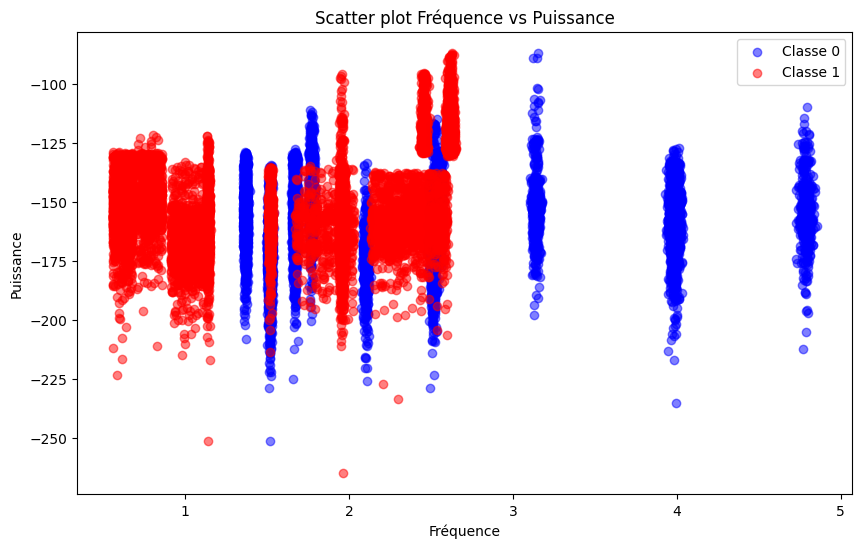

In [13]:
plt.figure(figsize=(10, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    sampled_indices = train_data[train_data['label'] == label].sample(10, replace=False).index
    for i in sampled_indices:
        plt.scatter(
            train_data.at[i, 'frequence'], 
            train_data.at[i, 'puissance'], 
            color=color, 
            alpha=0.5, 
            label=f'Classe {label}' if i == sampled_indices[0] else "")
plt.title("Scatter plot Fréquence vs Puissance")
plt.xlabel("Fréquence")
plt.ylabel("Puissance")
plt.legend()
plt.show()

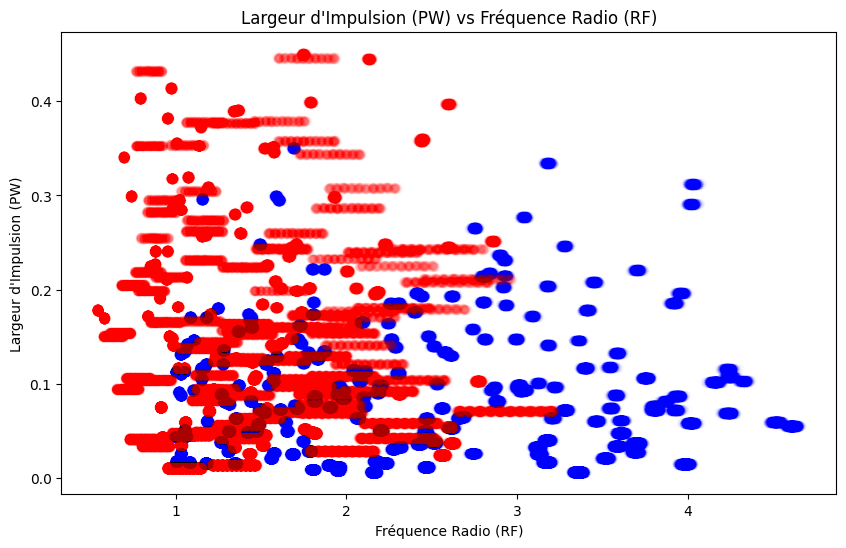

In [14]:
plt.figure(figsize=(10, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    sampled_indices = train_data[train_data['label'] == label].sample(200, replace=False).index
    for i in sampled_indices:
        plt.scatter(
            train_data.at[i, 'frequence'], 
            train_data.at[i, 'largeur'], 
            color=color, 
            alpha=0.01,
        )
plt.title("Largeur d'Impulsion (PW) vs Fréquence Radio (RF)")
plt.xlabel("Fréquence Radio (RF)")
plt.ylabel("Largeur d'Impulsion (PW)")
plt.show()

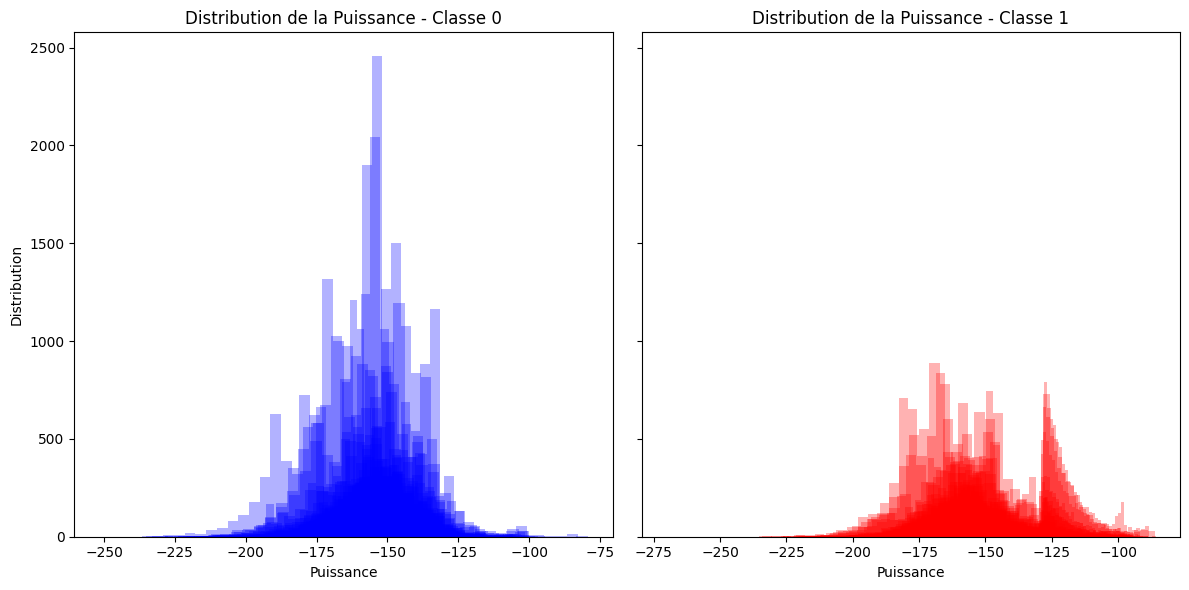

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for idx, (label, ax) in enumerate(zip([0, 1], [ax1, ax2])):
    sampled_indices = train_data[train_data['label'] == label].sample(100, replace=False).index
    for i in sampled_indices:
        puissance_values = np.array(train_data.at[i, 'puissance'])
        ax.hist(puissance_values, bins=30, alpha=0.3, color=('blue' if label == 0 else 'red'))
    ax.set_title(f"Distribution de la Puissance - Classe {label}")
    ax.set_xlabel("Puissance")
    if idx == 0:
        ax.set_ylabel("Distribution")

plt.tight_layout()
plt.show()

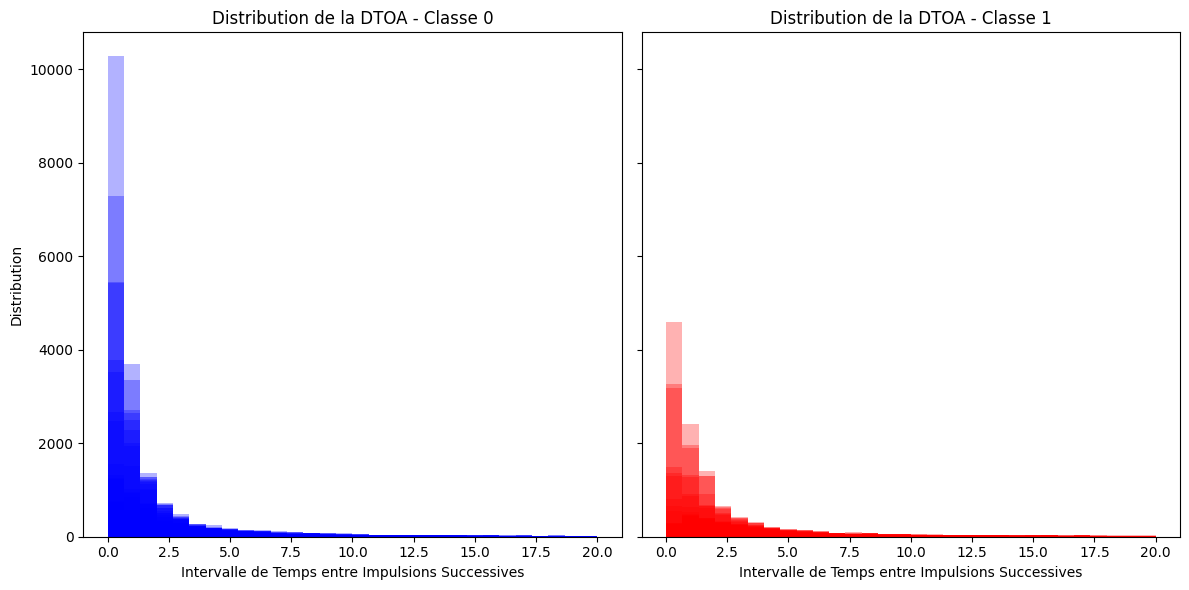

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for idx, (label, ax) in enumerate(zip([0, 1], [ax1, ax2])):
    sampled_indices = train_data[train_data['label'] == label].sample(100, replace=False).index
    for i in sampled_indices:
        dates = np.array(train_data.at[i, 'date'])
        dtoas = np.diff(dates)
        ax.hist(dtoas, bins=30, alpha=0.3, color=('blue' if label == 0 else 'red'), range=(0, 20))
    ax.set_title(f"Distribution de la DTOA - Classe {label}")
    ax.set_xlabel("Intervalle de Temps entre Impulsions Successives")
    if idx == 0:
        ax.set_ylabel("Distribution")

plt.tight_layout()
plt.show()

Calcul des moyennes DTOA: 100%|██████████| 2000/2000 [00:00<00:00, 13781.64it/s]


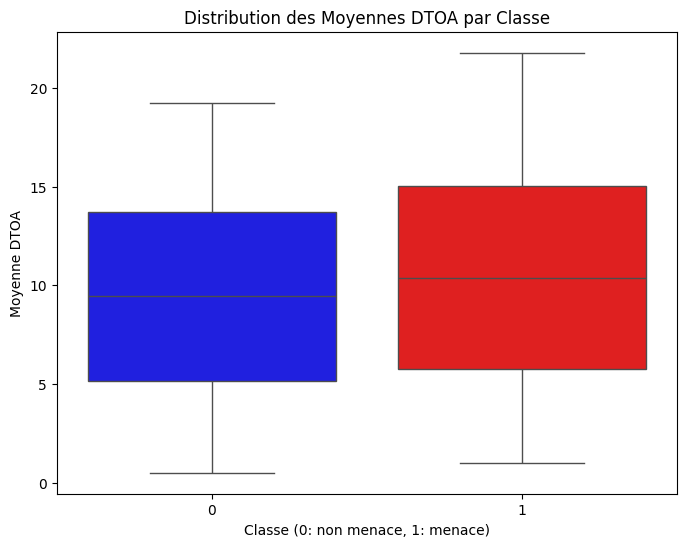

Calcul des écarts-types DTOA: 100%|██████████| 2000/2000 [00:00<00:00, 10686.07it/s]


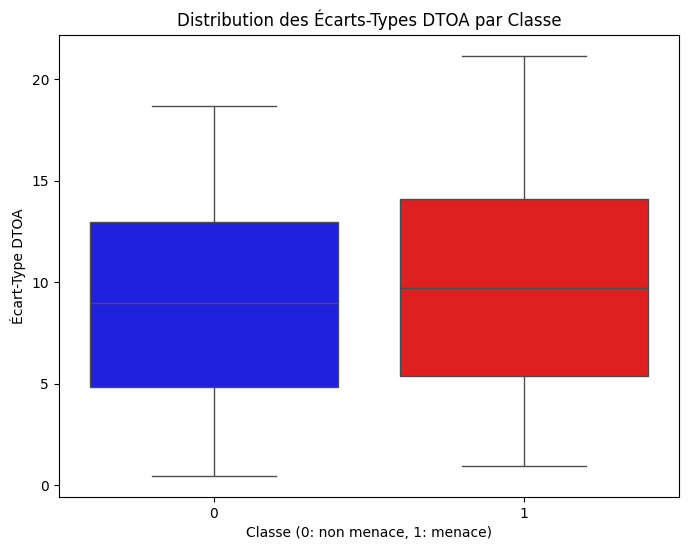

In [17]:
dtoa_means = []
for idx, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Calcul des moyennes DTOA"):
    dates = np.array(row['date'])
    dtoas = np.diff(dates)
    mean_dtoa = np.mean(dtoas)
    dtoa_means.append({'mean_dtoa': mean_dtoa, 'label': row['label']})
dtoa_means_df = pd.DataFrame(dtoa_means)
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='mean_dtoa', data=dtoa_means_df, hue='label', palette=['blue', 'red'], legend=False)
plt.title("Distribution des Moyennes DTOA par Classe")
plt.xlabel("Classe (0: non menace, 1: menace)")
plt.ylabel("Moyenne DTOA")
plt.show()

dtoa_stds = []
for idx, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Calcul des écarts-types DTOA"):
    dates = np.array(row['date'])
    dtoas = np.diff(dates)
    std_dtoa = np.std(dtoas)
    dtoa_stds.append({'std_dtoa': std_dtoa, 'label': row['label']})
dtoa_stds_df = pd.DataFrame(dtoa_stds)
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='std_dtoa', data=dtoa_stds_df, hue='label', palette=['blue', 'red'], legend=False)
plt.title("Distribution des Écarts-Types DTOA par Classe")
plt.xlabel("Classe (0: non menace, 1: menace)")
plt.ylabel("Écart-Type DTOA")
plt.show()

Calcul des étendues angulaires: 100%|██████████| 2000/2000 [00:00<00:00, 11618.15it/s]


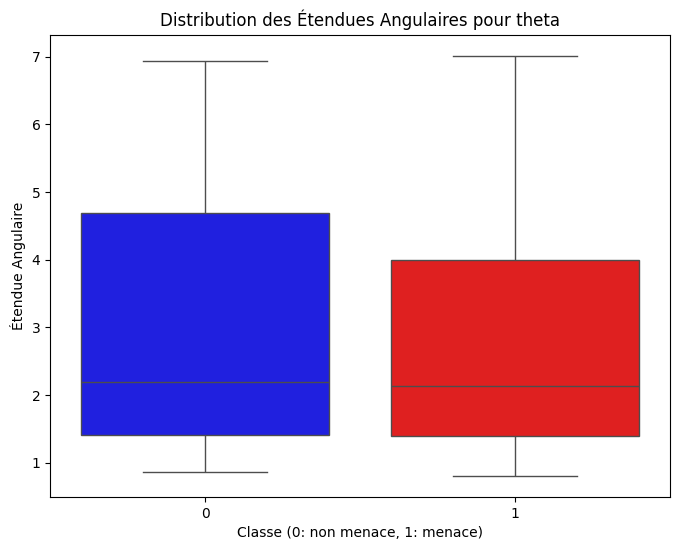

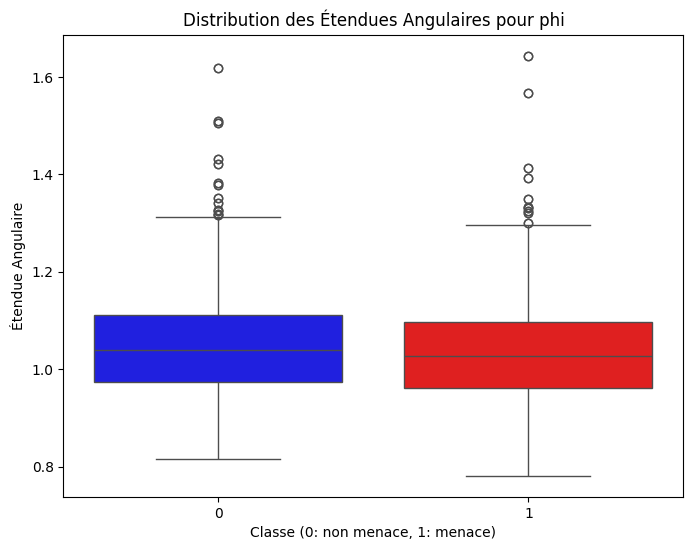

In [18]:
angular_data = []
for idx, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Calcul des étendues angulaires"):
    theta_values = np.array(row['theta'])
    phi_values = np.array(row['phi'])
    theta_range = np.max(theta_values) - np.min(theta_values)
    phi_range = np.max(phi_values) - np.min(phi_values)
    angular_data.append({'angle_type': 'theta', 'range': theta_range, 'label': row['label']})
    angular_data.append({'angle_type': 'phi', 'range': phi_range, 'label': row['label']})
    angular_data.append({'angle_type': 'phi', 'range': phi_range, 'label': row['label']})
angular_df = pd.DataFrame(angular_data)
for angle_type in ['theta', 'phi']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='label', y='range', data=angular_df[angular_df['angle_type'] == angle_type], hue='label', palette=['blue', 'red'], legend=False)
    plt.title(f"Distribution des Étendues Angulaires pour {angle_type}")
    plt.xlabel("Classe (0: non menace, 1: menace)")
    plt.ylabel("Étendue Angulaire")
    plt.show()

Then we try to extract features from the power plots. We think that there may be some useful pieces of information in the peaks of the power signals. We thus try to extract them for each instance using the scipy *find_peaks* function. 

To be able to use it accurately, we must tune its hyperparameters (*height* and *prominence*) first. To do so, we define a grid of hyparamteters and evaluate the performance of the *find_peaks* function across the grid in a supervised way. We count the number of peaks for a few signals manually on the plots below (plotted 5 signals at a time for more clarity), and we train the function to recognize them : we then take the combination of hyperparameter values that give us the best results. 

Then we extract a few parameters that we think are interesting, based on the number/heights/dates of the found peaks. It seems that when the data has no peaks, or has a lot of peaks, it is a threatening signal. 

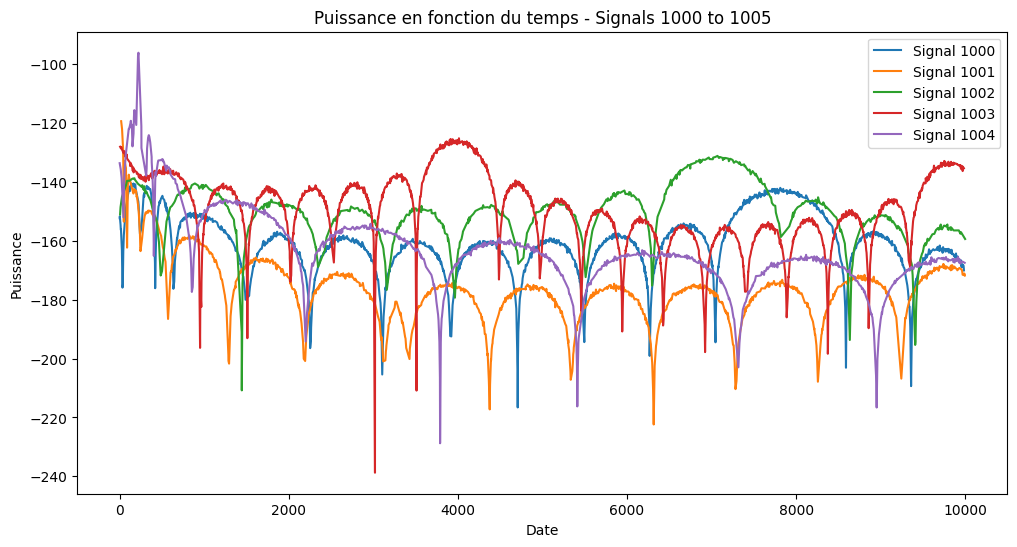

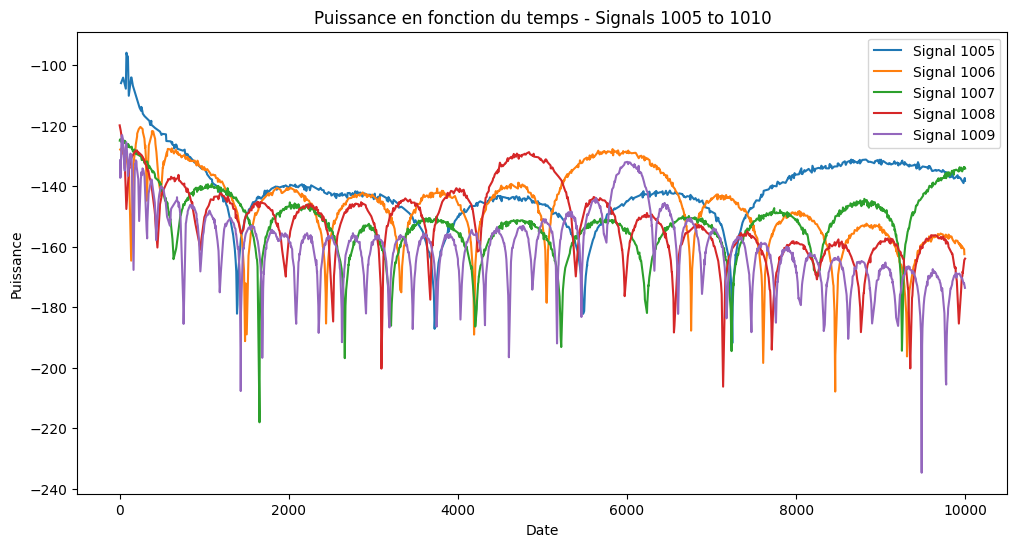

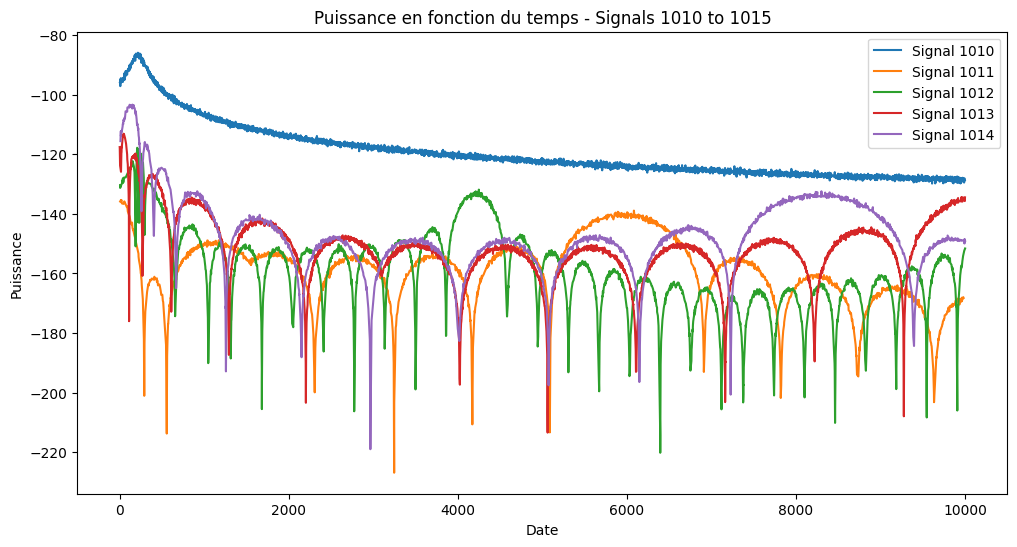

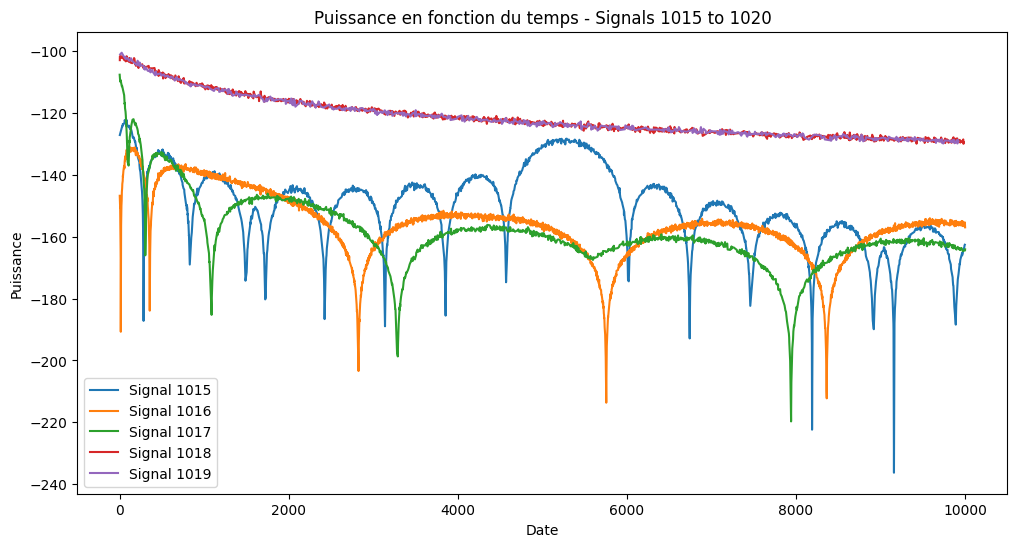

In [19]:
for j in range(4):
    plt.figure(figsize=(12, 6))
    for i in range(1000+j*5, 1000+(j+1)*5):
        plt.plot(train_data.iloc[i]['date'], train_data.iloc[i]['puissance'], label=f'Signal {i}')
        plt.title(f'Puissance en fonction du temps - Signals {1000+j*5} to {1000+(j+1)*5}')
        plt.xlabel('Date')
        plt.ylabel('Puissance')
    plt.legend()
    plt.show()

In [20]:
ground_truth_peaks = {1000: 14, 1001: 14, 1002: 12, 1003: 17, 1004: 9, 1005: 4, 1006: 12, 1007: 10, 1008: 18, 1009: 40, 1010: 0, 1011: 10, 1012: 29, 1013: 13, 1014: 11, 1015: 15, 1016: 5, 1017: 6, 1018: 0, 1019: 0}
                           
height_values = np.arange(0, -50, -5)
prominence_values = np.arange(1, 20, 1)

def count_peaks(puissance, height=None, prominence=None):
    peaks, _ = find_peaks(-puissance, height=height, prominence=prominence)
    return len(peaks)

best_params = None
best_score = np.inf

for height in tqdm(height_values, total=len(height_values)):
    for prominence in prominence_values:
        total = 0
        for i, nb_peaks in ground_truth_peaks.items():
            puissance = train_data.iloc[i]['puissance']
            peaks = count_peaks(puissance, height, prominence)
            total += np.abs(peaks - nb_peaks)
        if total < best_score:
            best_score = total
            best_params = (height, prominence)

print(f"Best params : height = {best_params[0]}, prominence = {best_params[1]} - Score : {best_score}")

100%|██████████| 10/10 [00:00<00:00, 11.96it/s]

Best params : height = 0, prominence = 7 - Score : 6


In [21]:
def train_peak_extractor(puissance, height=0, prominence=7):
    peaks, _ = find_peaks(-puissance, height=height, prominence=prominence)
    return len(peaks), 1 if len(peaks) > 0 else 0

def extract_peak_features(puissance, dates, height=0, prominence=7):
    peaks, properties = find_peaks(-puissance, height=height, prominence=prominence)
    
    if len(peaks) == 0:
        return {
            'mean_peak_height': 0,
            'std_peak_height': 0,
            'std_peak_prominence': 0,
            'mean_peak_interval': 1000,
            'std_peak_interval': 0,
            'num_peaks': 0
        }
    
    peak_heights = properties['peak_heights']
    peak_prominences = properties['prominences']
    peak_intervals = np.diff(dates[peaks])
    
    return {
        'mean_peak_height': np.mean(peak_heights) if len(peak_heights) > 0 else 0,
        'std_peak_height': np.std(peak_heights) if len(peak_heights) > 0 else 0,
        'std_peak_prominence': np.std(peak_prominences) if len(peak_prominences) > 0 else 0,
        'mean_peak_interval': np.mean(peak_intervals) if len(peak_intervals) > 0 else 0,
        'std_peak_interval': np.std(peak_intervals) if len(peak_intervals) > 0 else 0,
        'num_peaks': len(peaks)
    }


Classe 0 - Distribution du Nombre de Pics:
Avec pics: 1011 (100.00%)
Sans pics: 0 (0.00%)

Classe 1 - Distribution du Nombre de Pics:
Avec pics: 787 (79.58%)
Sans pics: 202 (20.42%)


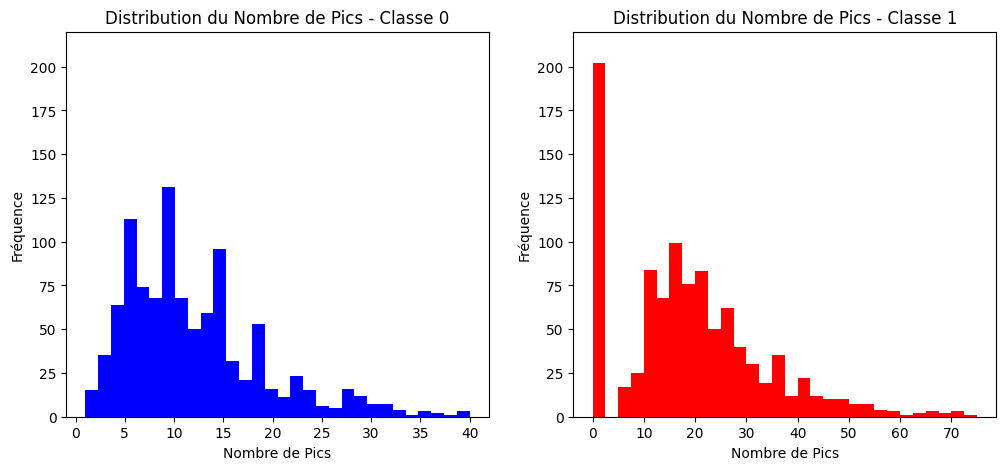

In [22]:
plt.figure(figsize=(12, 5))
for label in [0, 1]:
    num_peaks_list = []
    has_peaks_list = []
    for idx, row in train_data[train_data['label'] == label].iterrows():
        puissance = row['puissance']
        num_peaks, has_peak = train_peak_extractor(puissance)
        num_peaks_list.append(num_peaks)
        has_peaks_list.append(has_peak)
    
    print(f"\nClasse {label} - Distribution du Nombre de Pics:")
    print(f"Avec pics: {sum(np.array(num_peaks_list) > 0)} ({(sum(np.array(num_peaks_list) > 0) / len(num_peaks_list)) * 100:.2f}%)")
    print(f"Sans pics: {sum(np.array(num_peaks_list) == 0)} ({(sum(np.array(num_peaks_list) == 0) / len(num_peaks_list)) * 100:.2f}%)")

    # mettre les plots cote a cote
    plt.subplot(1, 2, label+1)
    plt.hist(num_peaks_list, bins=30, alpha=1, color=('blue' if label == 0 else 'red'))
    plt.title(f"Distribution du Nombre de Pics - Classe {label}")
    plt.xlabel("Nombre de Pics")
    plt.ylim(0, 220)
    plt.ylabel("Fréquence")

plt.show()

We then try to extract spectral features from the power signal, but it is difficult because the impulsions are not regularly sampled (the sampling period varies). Yet we can see that the spectral features that we obtain allow us to discriminate a lot of threatening signals (we're not concerned yet that those could have already been discriminated by the features that we built previously, it will only be a concern when we will focus on feature selection). 

Extraction features spectrales: 100%|██████████| 2000/2000 [01:41<00:00, 19.79it/s]


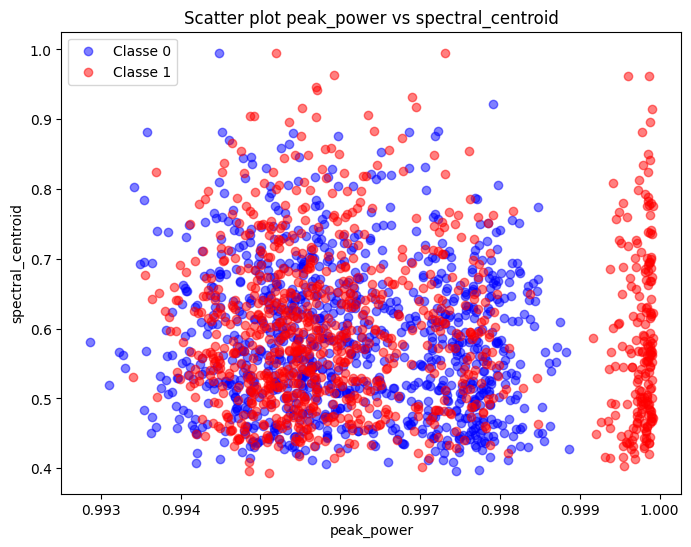

In [23]:
def extract_spectral_features(dates, power_values):
    freqs = np.linspace(0.01, 10, 500)
    pgram = lombscargle(dates/1000, power_values, freqs, normalize=True)
    features = {
        'peak_power': np.max(pgram),
        'spectral_centroid': np.sum(freqs * pgram) / np.sum(pgram),
    }
    return features

spectral_features = []
for idx, row in tqdm(train_data.iterrows(), desc="Extraction features spectrales", total=len(train_data)):
    dates = np.array(row['date'])
    puissance = np.array(row['puissance'])
    
    features = extract_spectral_features(dates, puissance)
    features['label'] = row['label']
    spectral_features.append(features)

spectral_df = pd.DataFrame(spectral_features)
feature_names = ['peak_power', 'spectral_centroid']
for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        plt.figure(figsize=(8, 6))
        for label, color in zip([0, 1], ['blue', 'red']):
            subset = spectral_df[spectral_df['label'] == label]
            plt.scatter(subset[feature_names[i]], subset[feature_names[j]], color=color, alpha=0.5, label=f'Classe {label}')
        plt.title(f"Scatter plot {feature_names[i]} vs {feature_names[j]}")
        plt.xlabel(feature_names[i])
        plt.ylabel(feature_names[j])
        plt.legend()
        plt.show()

We build a more robust measure of the amplitude of the frequence signal than the standard deviation (namely the interquartile range). 

Calcul des amplitudes robustes: 100%|██████████| 2000/2000 [00:00<00:00, 2879.35it/s]


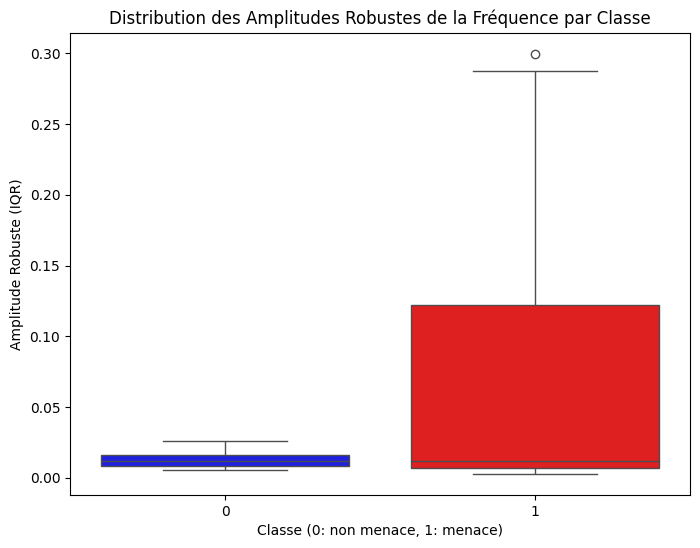

In [24]:
import scipy.stats as stats

robust_amplitudes = []
for idx, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Calcul des amplitudes robustes"):
    frequence_values = np.array(row['frequence'])
    iqr = stats.iqr(frequence_values)
    robust_amplitudes.append({'robust_amplitude': iqr, 'label': row['label']})
robust_amplitudes_df = pd.DataFrame(robust_amplitudes)
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='robust_amplitude', data=robust_amplitudes_df, hue='label', palette=['blue', 'red'], legend=False)
plt.title("Distribution des Amplitudes Robustes de la Fréquence par Classe")
plt.xlabel("Classe (0: non menace, 1: menace)")
plt.ylabel("Amplitude Robuste (IQR)")
plt.show()

We then compute all of our features on the train and test set and stack them into 2 data matrices. 

In [25]:
features_list = []
for idx, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Calcul des features complètes"):
    feature_dict = {}
    for col in ['largeur', 'frequence', 'puissance', 'theta', 'phi']:
        values = np.array(row[col])
        feature_dict[f'{col}_mean'] = np.mean(values)
        feature_dict[f'{col}_std'] = np.std(values)
    frequence = np.array(row['frequence'])
    feature_dict['max_frequence'] = np.max(frequence)
    feature_dict['min_frequence'] = np.min(frequence)
    
    # DTOA features
    dates = np.array(row['date'])
    dtoas = np.diff(dates)
    feature_dict['std_dtoa'] = np.std(dtoas)
    
    # Angular range features
    theta_values = np.array(row['theta'])
    phi_values = np.array(row['phi'])
    feature_dict['theta_range'] = np.max(theta_values) - np.min(theta_values)
    feature_dict['phi_range'] = np.max(phi_values) - np.min(phi_values)
    
    # Spectral features
    puissance_values = np.array(row['puissance'])
    feature_dict['max_power'] = np.max(row['puissance'])
    zero_crossings = np.sum(np.diff(np.sign(puissance_values - np.mean(puissance_values))) != 0)
    feature_dict['zero_crossings'] = zero_crossings / len(puissance_values)
    spectral_features = extract_spectral_features(dates, puissance_values)
    feature_dict.update(spectral_features)

    # Peak features
    peaks_features = extract_peak_features(puissance_values, dates, height=0, prominence=7)
    feature_dict.update(peaks_features)

    # Robust amplitude feature
    frequence_values = np.array(row['frequence'])
    iqr = stats.iqr(frequence_values)
    feature_dict['frequence_robust_amplitude'] = iqr
    
    feature_dict['label'] = row['label']
    features_list.append(feature_dict)

features_df = pd.DataFrame(features_list)
features_df.to_csv('train_features.csv', index=False)

Calcul des features complètes: 100%|██████████| 2000/2000 [01:42<00:00, 19.47it/s]


In [26]:
features_list = []
for idx, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Calcul des features complètes"):
    feature_dict = {}
    for col in ['largeur', 'frequence', 'puissance', 'theta', 'phi']:
        values = np.array(row[col])
        feature_dict[f'{col}_mean'] = np.mean(values)
        feature_dict[f'{col}_std'] = np.std(values)
    frequence = np.array(row['frequence'])
    feature_dict['max_frequence'] = np.max(frequence)
    feature_dict['min_frequence'] = np.min(frequence)
    
    # DTOA features
    dates = np.array(row['date'])
    dtoas = np.diff(dates)
    feature_dict['std_dtoa'] = np.std(dtoas)
    
    # Angular range features
    theta_values = np.array(row['theta'])
    phi_values = np.array(row['phi'])
    feature_dict['theta_range'] = np.max(theta_values) - np.min(theta_values)
    feature_dict['phi_range'] = np.max(phi_values) - np.min(phi_values)
    
    # Spectral features
    puissance_values = np.array(row['puissance'])
    feature_dict['max_power'] = np.max(row['puissance'])
    zero_crossings = np.sum(np.diff(np.sign(puissance_values - np.mean(puissance_values))) != 0)
    feature_dict['zero_crossings'] = zero_crossings / len(puissance_values)
    spectral_features = extract_spectral_features(dates, puissance_values)
    feature_dict.update(spectral_features)

    # Peak features
    peaks_features = extract_peak_features(puissance_values, dates, height=0, prominence=7)
    feature_dict.update(peaks_features)

    # Robust amplitude feature
    frequence_values = np.array(row['frequence'])
    iqr = stats.iqr(frequence_values)
    feature_dict['frequence_robust_amplitude'] = iqr
    
    feature_dict['label'] = row['label']
    features_list.append(feature_dict)

features_df = pd.DataFrame(features_list)
features_df.to_csv('test_features.csv', index=False)

Calcul des features complètes: 100%|██████████| 800/800 [00:44<00:00, 17.79it/s]


We can try to assess if our features allow us to discriminate the classes effectively by clustering in the embedded space. For example t-SNE is a powerful visualization algorithm : it non-linearly maps the points in the features space into a 2D space by trying to preserve the local structure of the data (similar data points in the embedded space will be close in the 2D space). If our feature are qualitative, we expect to see 2 clusters on the visualization. 

We see 2 clusters on the plot. The first one is very homogeneous and contains only threatening signals : this means that our features make it possible to classify these signals accurately. The second one contains both threatening and non-threatening signals; yet we can see that points that belong to the same class tend to group together within the cluster (e.g. they can be locally separable). This let us hope that we will be able to correctly classify most of them later on. 

Moreover, when we plot the correlation matrix, it seems that our feature are mostly decorrelated with each other but correlated with the target. Overall, the feature extraction step seems quite qualitative. We can now move on classifying the signals. 

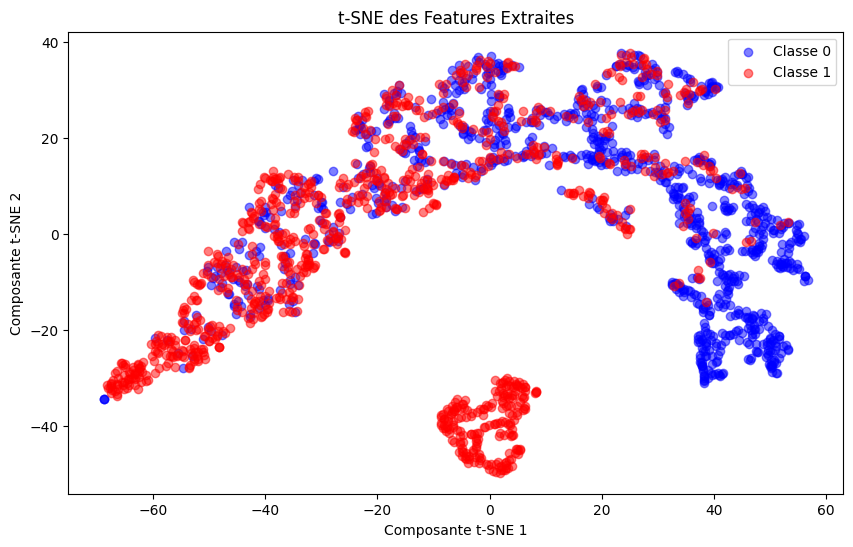

In [27]:
# visualisation t-SNE des features extraites avec une couleur différente pour chaque classe (menace/non menace).
from sklearn.manifold import TSNE
features_df = pd.read_csv('train_features.csv')
X = features_df.drop(columns=['label']).values
y = features_df['label'].values
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(pd.DataFrame(X).fillna(0).values)
plt.figure(figsize=(10, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    subset = X_tsne[y == label]
    plt.scatter(subset[:, 0], subset[:, 1], color=color, alpha=0.5, label=f'Classe {label}')
plt.title("t-SNE des Features Extraites")
plt.xlabel("Composante t-SNE 1")
plt.ylabel("Composante t-SNE 2")
plt.legend()
plt.show()

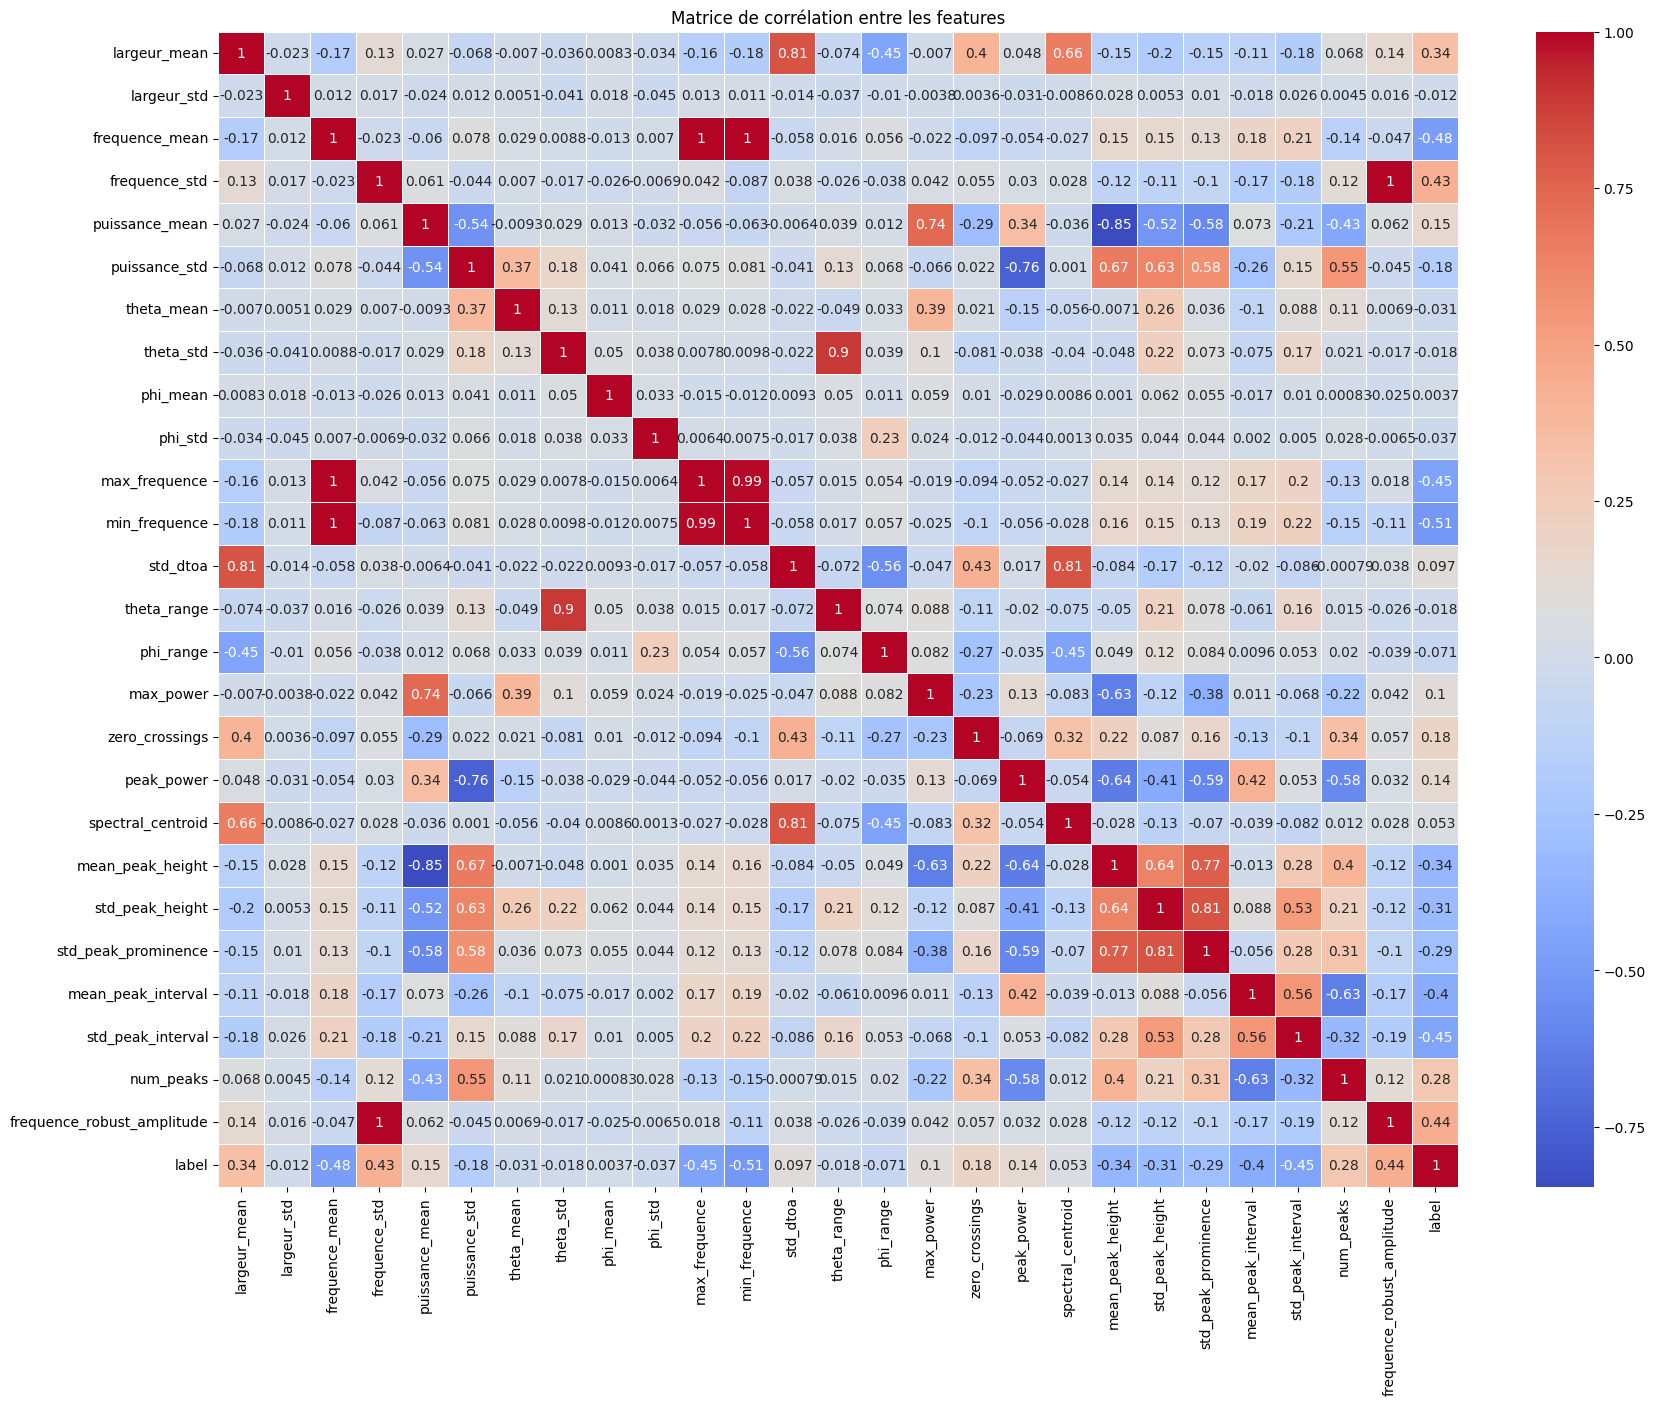

In [28]:
correlation_matrix = features_df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title('Matrice de corrélation entre les features')
plt.show()

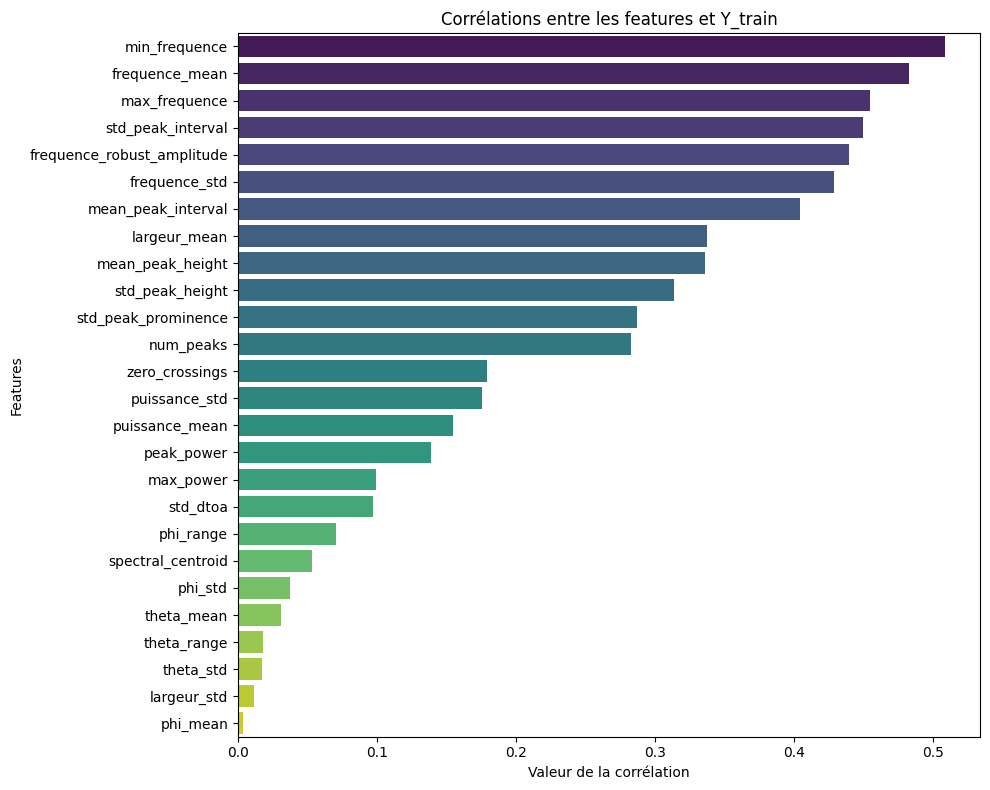

In [29]:
correlations_with_target = features_df.drop(columns=['label']).apply(lambda x: x.corr(pd.Series(features_df['label'].values)), axis=0)

# On trie les corrélations par ordre décroissant (en valeur absolue)
correlations_with_target_sorted = correlations_with_target.abs().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations_with_target_sorted.values,y=correlations_with_target_sorted.index, palette="viridis",hue=correlations_with_target_sorted.index)
plt.title("Corrélations entre les features et Y_train")
plt.xlabel("Valeur de la corrélation")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [30]:
features_df.columns.tolist()

['largeur_mean',
 'largeur_std',
 'frequence_mean',
 'frequence_std',
 'puissance_mean',
 'puissance_std',
 'theta_mean',
 'theta_std',
 'phi_mean',
 'phi_std',
 'max_frequence',
 'min_frequence',
 'std_dtoa',
 'theta_range',
 'phi_range',
 'max_power',
 'zero_crossings',
 'peak_power',
 'spectral_centroid',
 'mean_peak_height',
 'std_peak_height',
 'std_peak_prominence',
 'mean_peak_interval',
 'std_peak_interval',
 'num_peaks',
 'frequence_robust_amplitude',
 'label']

In [31]:
df_train = pd.read_csv('train_features.csv')
df_test = pd.read_csv('test_features.csv')
X_train_full = df_train.drop("label",axis=1)
X_test = df_test.drop("label",axis=1)
y_train_full = df_train["label"]
y_test = df_test["label"]

# Model Training

Let's first try to train our models on the full dataset with default hyperparameters in order to assess our starting performances.

In [32]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000,random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

for name, model in models.items():
    print(f"\n{'='*50}\nTraining {name}")
    model.fit(X_train_full, y_train_full)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    results = pd.concat([results, pd.DataFrame({
        "Model": [name],
        "Accuracy": [acc],
        "Precision": [prec],
        "Recall": [rec],
        "F1-Score": [f1]
    })], ignore_index=True)
    
    print(f"\nConfusion Matrix:\n{cm}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

results = results.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("\n\n========== Overall Model Comparison ==========")
print(results)


Training Logistic Regression

Confusion Matrix:
[[362  53]
 [ 53 332]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       415
           1       0.86      0.86      0.86       385

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800


Training K-Nearest Neighbors

Confusion Matrix:
[[297 118]
 [118 267]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       415
           1       0.69      0.69      0.69       385

    accuracy                           0.70       800
   macro avg       0.70      0.70      0.70       800
weighted avg       0.70      0.70      0.70       800


Training Support Vector Machine

Confusion Matrix:
[[275 140]
 [ 93 292]]

Classification Report:
              precision    recall  f1-score   support



We managed to get over 0.88 accuracy on two models (Gradient Boosting and Random Forest). These performances are way better than our baseline model acheving over 18% more accuracy.

## Fine tuning 

Now that we have a good idea of our models performances, we can now try to fine tune each model's hyperparameter in order to get the highest performances possible. In order to have a good finetuning and not biased with the test set, we will split the training set in a train and val dataset. The models will be trained on the train set and we will evaluate the efficiency of the hyperparameters on the validation dataset.

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

models_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000,random_state=42),
        "params": {
            "model__C": np.logspace(-3, 2, 10),
            "model__penalty": ["l2"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "model__max_depth": [None, 5, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": np.arange(50, 300, 50),
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": np.arange(3, 20, 2),
            "model__weights": ["uniform", "distance"]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "model__n_estimators": np.arange(50, 300, 50),
            "model__learning_rate": np.logspace(-3, 0, 10),
            "model__max_depth": [2, 3, 4, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
        "params": {
            "model__n_estimators": np.arange(50, 300, 50),
            "model__learning_rate": np.logspace(-3, 0, 10),
            "model__max_depth": [3, 4, 5, 6]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "model__n_estimators": np.arange(50, 300, 50),
            "model__learning_rate": np.logspace(-3, 0, 10)
        }
    }
}


def tune_and_evaluate(models_params, X_train, y_train, X_val, y_val, n_iter=30):
    best_models = {}
    val_scores = []

    for name, config in models_params.items():
        print(f"\n{'='*60}\n Tuning {name}")

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', config['model'])
        ])

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=config['params'],
            n_iter=n_iter,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        y_pred_val = best_model.predict(X_val)
        acc = accuracy_score(y_val, y_pred_val)
        f1 = f1_score(y_val, y_pred_val, average='weighted')

        val_scores.append({
            'Model': name,
            'Accuracy': acc,
            'F1': f1,
            'Best Params': search.best_params_
        })

        best_models[name] = best_model
        print(f"{name} | Val Accuracy: {acc:.2f}, F1: {f1:.2f}")
        print(f"Best Params: {search.best_params_}")

    return pd.DataFrame(val_scores).sort_values(by='Accuracy', ascending=False), best_models


results_df, best_models = tune_and_evaluate(models_params, X_train, y_train, X_val, y_val)

print("\n\nValidation Results:")
print(results_df)


 Tuning Logistic Regression
Logistic Regression | Val Accuracy: 0.91, F1: 0.91
Best Params: {'model__penalty': 'l2', 'model__C': np.float64(2.1544346900318843)}

 Tuning Decision Tree
Decision Tree | Val Accuracy: 0.89, F1: 0.88
Best Params: {'model__min_samples_split': 2, 'model__max_depth': 5}

 Tuning Random Forest
Random Forest | Val Accuracy: 0.91, F1: 0.91
Best Params: {'model__n_estimators': np.int64(150), 'model__min_samples_split': 2, 'model__max_depth': 20}

 Tuning K-Nearest Neighbors
K-Nearest Neighbors | Val Accuracy: 0.88, F1: 0.88
Best Params: {'model__weights': 'distance', 'model__n_neighbors': np.int64(17)}

 Tuning Gradient Boosting
Gradient Boosting | Val Accuracy: 0.89, F1: 0.89
Best Params: {'model__n_estimators': np.int64(250), 'model__max_depth': 2, 'model__learning_rate': np.float64(0.1)}

 Tuning XGBoost
XGBoost | Val Accuracy: 0.91, F1: 0.91
Best Params: {'model__n_estimators': np.int64(200), 'model__max_depth': 5, 'model__learning_rate': np.float64(0.0215443

Now that we have our fine tuned hyperparameters, we can now retrain our models on the full training set with the good hyperparameters and then evaluate our model performances on the test set.

In [34]:
print("\n\nRetraining each best model on full training data before testing")

X_full_train = np.concatenate([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])

final_models = {}
test_scores = []

for model_name, best_model in best_models.items():
    print(f"\n{'='*60}\nRetraining {model_name} on full training data")

    best_params = results_df.loc[results_df['Model'] == model_name, 'Best Params'].values[0]

    base_model = models_params[model_name]['model']

    final_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', base_model)
    ])

    final_pipe.set_params(**best_params)

    final_pipe.fit(X_full_train, y_full_train)
    final_models[model_name] = final_pipe

    y_pred_test = final_pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average='weighted')

    test_scores.append({
        'Model': model_name,
        'Test Accuracy': acc,
        'Test F1': f1,
    })

test_results = pd.DataFrame(test_scores).sort_values(by='Test Accuracy', ascending=False)

print("\n\nFinal Test Results (after retraining on full train set):")
print(test_results)

best_model_name = test_results.iloc[0]['Model']
print(f"\nBest Performing Model on Test Set: {best_model_name}")




Retraining each best model on full training data before testing

Retraining Logistic Regression on full training data

Retraining Decision Tree on full training data

Retraining Random Forest on full training data

Retraining K-Nearest Neighbors on full training data

Retraining Gradient Boosting on full training data

Retraining XGBoost on full training data

Retraining AdaBoost on full training data


Final Test Results (after retraining on full train set):
                 Model  Test Accuracy   Test F1
6             AdaBoost        0.89625  0.896177
5              XGBoost        0.89000  0.889948
4    Gradient Boosting        0.88500  0.885026
2        Random Forest        0.88375  0.883686
0  Logistic Regression        0.88000  0.879988
1        Decision Tree        0.86000  0.860047
3  K-Nearest Neighbors        0.83750  0.836944

Best Performing Model on Test Set: AdaBoost


The first thing that we see is that the test set is very different from the training set. Indeed, with our train and va datasets, we managed to have over 90 % accuracy while now on the test set we "only" have 89.625 accuracy.
Other than that we have excellent performances. As mentionned above, we managed to get over 89% accuracy with our AdaBoost model. Overall, every model that we evaluated managed to get over 80% accuracy which is excellent. However, our dataset is still very big which slows everything a lot. In a real-life scenario we might needd real-time computing efficiency to detect if there is a menace or not. In order to speed things up, we decided to explore feature seection in order to shrink the size of our dataset.

## Feature selection

The idea in this part is to reduce the size of our dataset, remove redundant inforamtion and try to acheive similar performances with a smaller dataset

### ANOVA


**ANOVA (Analysis of Variance)** is a statistical method used to identify which features are most relevant for predicting a categorical target variable.

It works by comparing the **variance between groups** (different target classes) to the **variance within each group**:

- If a feature’s values vary **a lot between classes** but **little within a class**, it’s likely informative.  
- ANOVA computes an **F-score** for each feature:
  $$F = \frac{\text{variance between groups}}{\text{variance within groups}}$$
- A **higher F-score** means the feature better separates the classes.

In our case, we performed ANOVA and then manually selected features based on their **F-statistics**.  

In [35]:
labels = y_train_full
statistics, pvalues = f_oneway(
    X_train_full[labels == 0], X_train_full[labels == 1]
)

In [36]:
for ind in statistics.argsort()[::-1]:
    print(f"{X_train_full.columns[ind]}: {statistics[ind]:.3f}")

min_frequence: 695.205
frequence_mean: 605.614
max_frequence: 519.365
std_peak_interval: 504.726
frequence_robust_amplitude: 478.255
frequence_std: 448.739
mean_peak_interval: 389.163
largeur_mean: 256.441
mean_peak_height: 254.089
std_peak_height: 217.424
std_peak_prominence: 179.187
num_peaks: 172.957
zero_crossings: 65.963
puissance_std: 63.229
puissance_mean: 49.162
peak_power: 39.269
max_power: 20.028
std_dtoa: 18.884
phi_range: 10.087
spectral_centroid: 5.708
phi_std: 2.796
theta_mean: 1.919
theta_range: 0.640
theta_std: 0.624
largeur_std: 0.269
phi_mean: 0.027


We observe that the features with strong F-value are once again the features dealing with frequency and peaks. We note that the frequence_robust_amplitude and largeur_mean also got great F-value. We can now filter the features with small values. We sorted the features by their ANOVA scores in descending order and removed those with an F-value below 15.

In [37]:
full_features = X_train_full.copy()
for ind in statistics.argsort()[::-1]:
    if statistics[ind] < 15:
        full_features = full_features.drop(full_features.columns[ind],axis=1)

print(f"We now have : {len(full_features.columns)} features")
full_features.columns

We now have : 18 features


Index(['largeur_mean', 'frequence_mean', 'frequence_std', 'puissance_mean',
       'puissance_std', 'theta_std', 'max_frequence', 'min_frequence',
       'theta_range', 'max_power', 'peak_power', 'spectral_centroid',
       'std_peak_height', 'std_peak_prominence', 'mean_peak_interval',
       'std_peak_interval', 'num_peaks', 'frequence_robust_amplitude'],
      dtype='object')

We can see that we removed almost all the features that were relative to the angle phi which is consistent with our first part analysis.

### Multicolinearity

Even though we already removed features with no to low informations (for the target class), we might still have a lot of colinearity whitin our dataset.

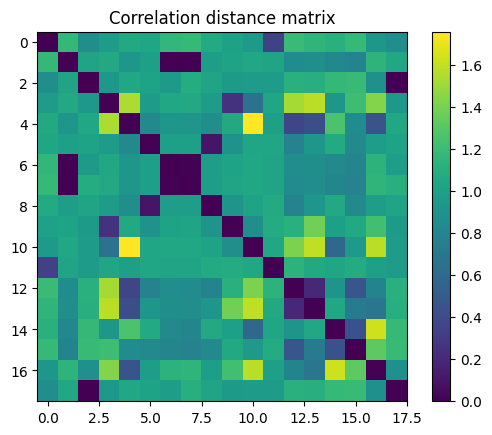

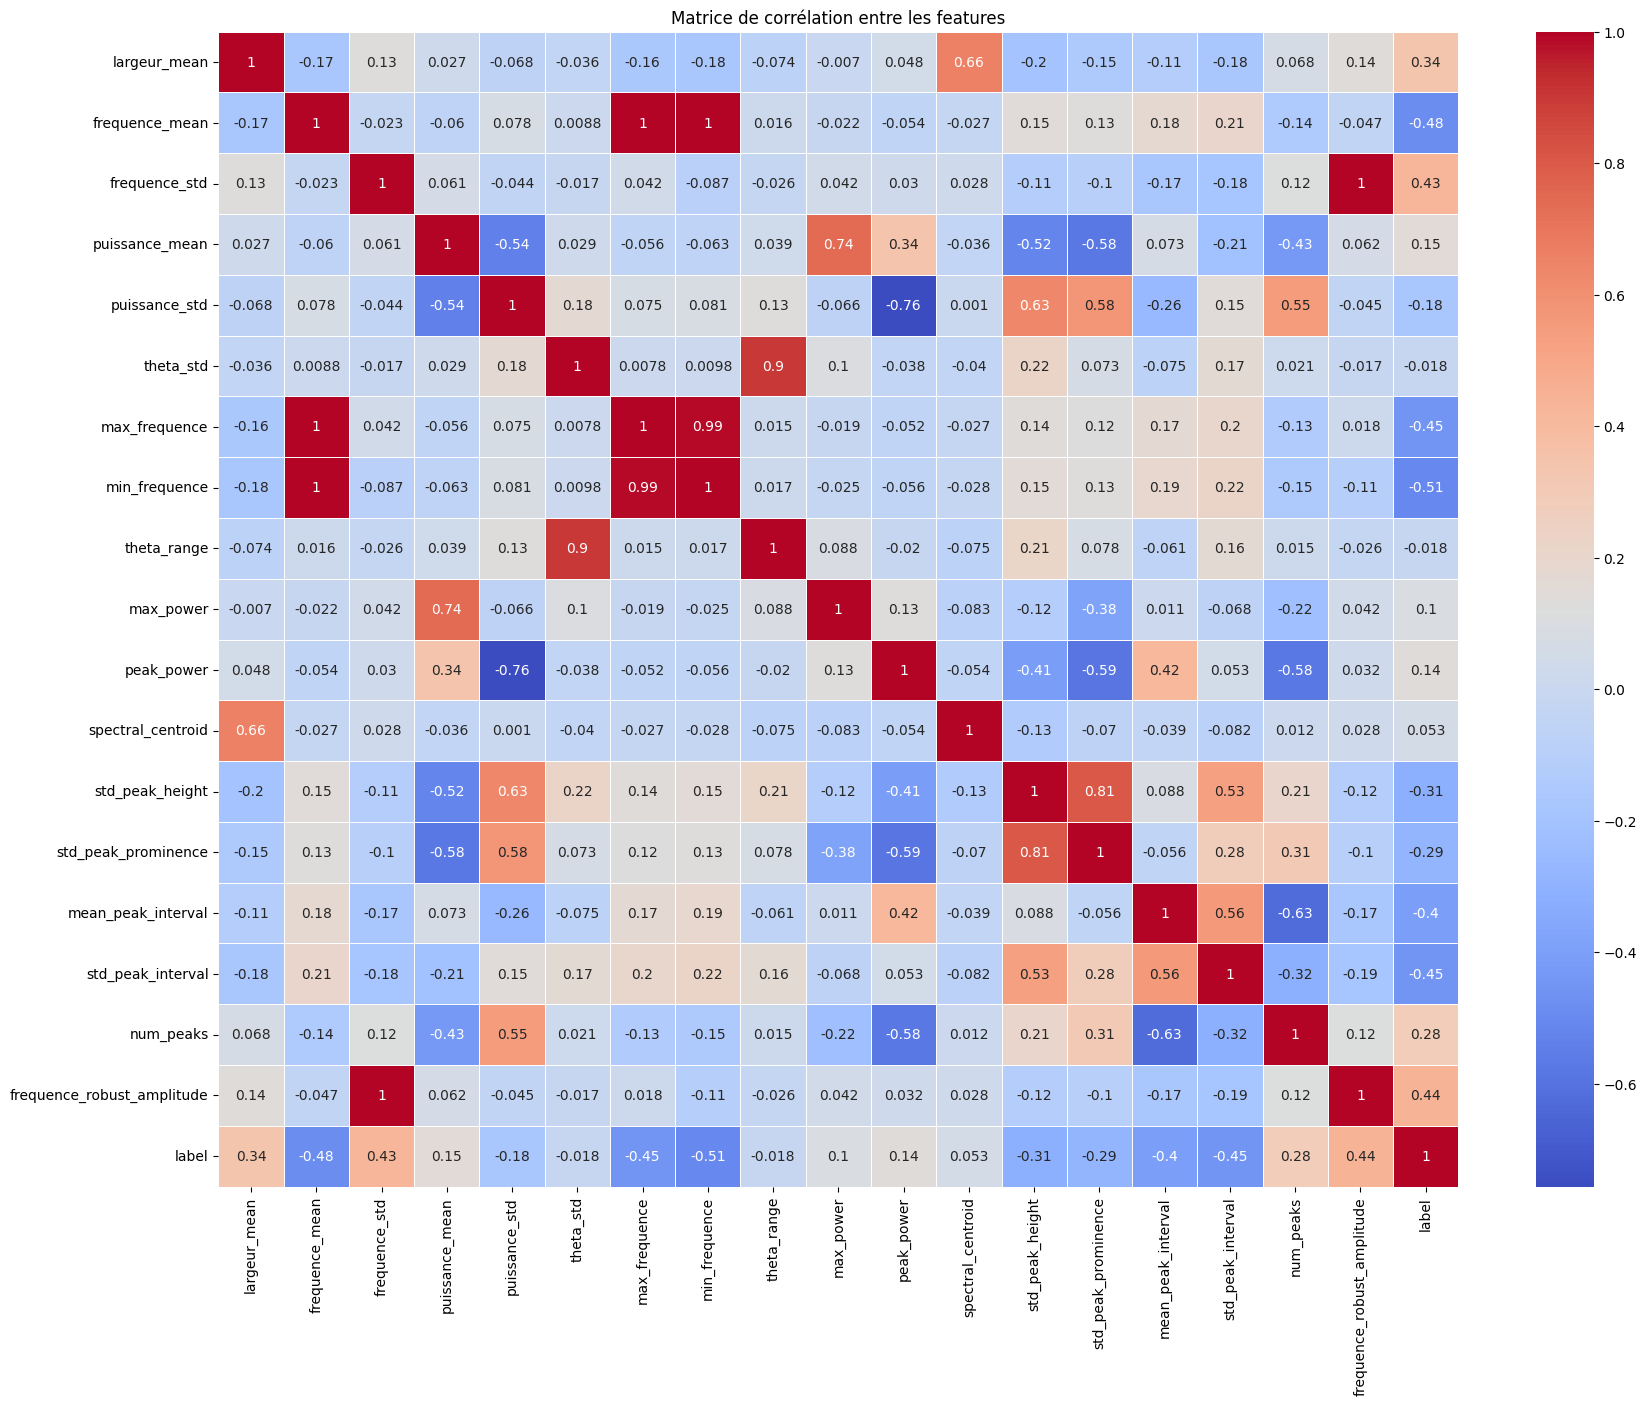

In [38]:
corr = pdist(full_features.to_numpy().T, metric="correlation")  # distance matrix
plt.imshow(squareform(corr))
plt.colorbar()
plt.title("Correlation distance matrix")
plt.show()
temp_df = pd.concat([full_features, pd.Series(y_train_full, name='label')], axis=1)
correlation_matrix = temp_df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title('Matrice de corrélation entre les features')
plt.show()

From the correlation plots, we can see that several features remain highly correlated with one another. Such features often carry redundant information, which can make models less efficient or even lead to overfitting. To fix this issue, we will apply a hierarchical clustering approach on the feature correlation matrix to identify and remove groups of strongly correlated features.

The idea is to:
1. Compute pairwise correlations between all features.  
2. Cluster features based on their correlation distances.  
3. Within each cluster of highly correlated features, keep only one representative feature.

We define a correlation threshold of 0.9, meaning we only remove features that are almost identical in the information they carry.


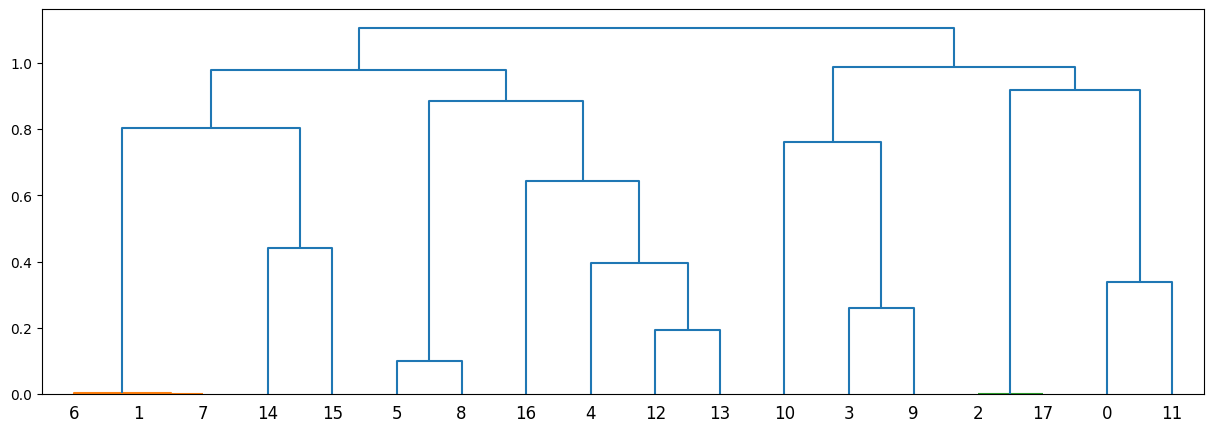

In [39]:
correlation_threshold = 0.9
fig, ax = plt.subplots(figsize=(15, 5))
corr_linkage = hierarchy.average(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax, color_threshold=1 - correlation_threshold
)

In [40]:
# compute the clusters
cluster_ids = hierarchy.fcluster(
    corr_linkage, 1 - correlation_threshold, criterion="distance"
)

# print the largest clusters
largest_cluster_ind = np.bincount(cluster_ids).argmax()
print(
    f"The largest cluster is {full_features.columns[cluster_ids==largest_cluster_ind].tolist()}."
)

# for each cluster, only keep the first feature
keep_features = list()
for cluster in np.unique(cluster_ids):
    cluster_indexes = np.where(cluster_ids == cluster)[0]
    keep_features.append(full_features.columns[cluster_indexes[0]])

The largest cluster is ['frequence_mean', 'max_frequence', 'min_frequence'].


We identified two distinct clusters of correlated features. The largest cluster includes the mean, minimum, and maximum frequency features, which all capture very similar information in our case. Since these features are strongly correlated, we can keep only one of them without losing much informational value, allowing the model to be simpler.

In [41]:
selected_features = full_features[keep_features]
print(f"We now have {len(selected_features.columns)} features")
selected_features

We now have 15 features


frequence_mean  mean_peak_interval  std_peak_interval  theta_std  \
0           2.202149          401.709792         192.327003   0.477428   
1           2.996037          671.423857         303.008482   0.347991   
2           0.986435          375.878320          71.226282   0.163853   
3           1.665592         1131.043286         321.695444   0.213341   
4           2.205039          805.894500         376.057754   0.674727   
...              ...                 ...                ...        ...   
1995        1.247535          313.729613         131.643845   0.522763   
1996        1.878550          825.549545         355.249584   0.843644   
1997        1.917764          688.000857         255.988307   0.175318   
1998        2.040005          823.133583         280.437803   0.172370   
1999        1.869359         1268.506571         518.640653   0.554065   

      theta_range  std_peak_height  std_peak_prominence  puissance_std  \
0        2.911992        17.409645            12.305457      14.271022   
1        6.233481         8.971866            11.247798      11.655734   
2        1.212576        12.443850            12.310421      12.164566   
3        1.575488         9.369523            13.961498       9.564745   
4        6.446544        18.081819            11.469825      11.162828   
...           ...              ...                  ...            ...   
1995     6.259624        21.867520            15.428572      13.209612   
1996     6.539567        13.536135            10.671028      11.059385   
1997     1.350713        16.920637            15.973408      13.187461   
1998     1.281078        12.809214            10.938959      10.765854   
1999     6.324436        15.250094            14.502819      11.025538   

      num_peaks  puissance_mean   max_power  peak_power  frequence_std  \
0            25     -151.168286 -107.706444    0.993823       0.008909   
1            15     -152.733649 -127.176800    0.995137       0.012328   
2            26     -171.253159 -145.868879    0.995529       0.004003   
3             8     -149.829714 -132.493661    0.997136       0.006610   
4            13     -177.214144 -148.379465    0.997859       0.008529   
...         ...             ...         ...         ...            ...   
1995         32     -184.618028 -150.112861    0.996062       0.070869   
1996         12     -147.789485 -125.834376    0.996365       0.109245   
1997         15     -148.943209 -120.246247    0.994490       0.007621   
1998         13     -151.170110 -121.686685    0.995118       0.008051   
1999          8     -158.930224 -135.080964    0.995496       0.007451   

      largeur_mean  spectral_centroid  
0         0.292003           0.525830  
1         0.137017           0.491529  
2         0.201962           0.679526  
3         0.069014           0.553128  
4         0.324018           0.645203  
...            ...                ...  
1995      0.143991           0.536148  
1996      0.159961           0.578804  
1997      0.028000           0.551159  
1998      0.107006           0.560426  
1999      0.222004           0.642149  

[2000 rows x 15 columns]

We already removed over 10 features and we now have 15 features left.

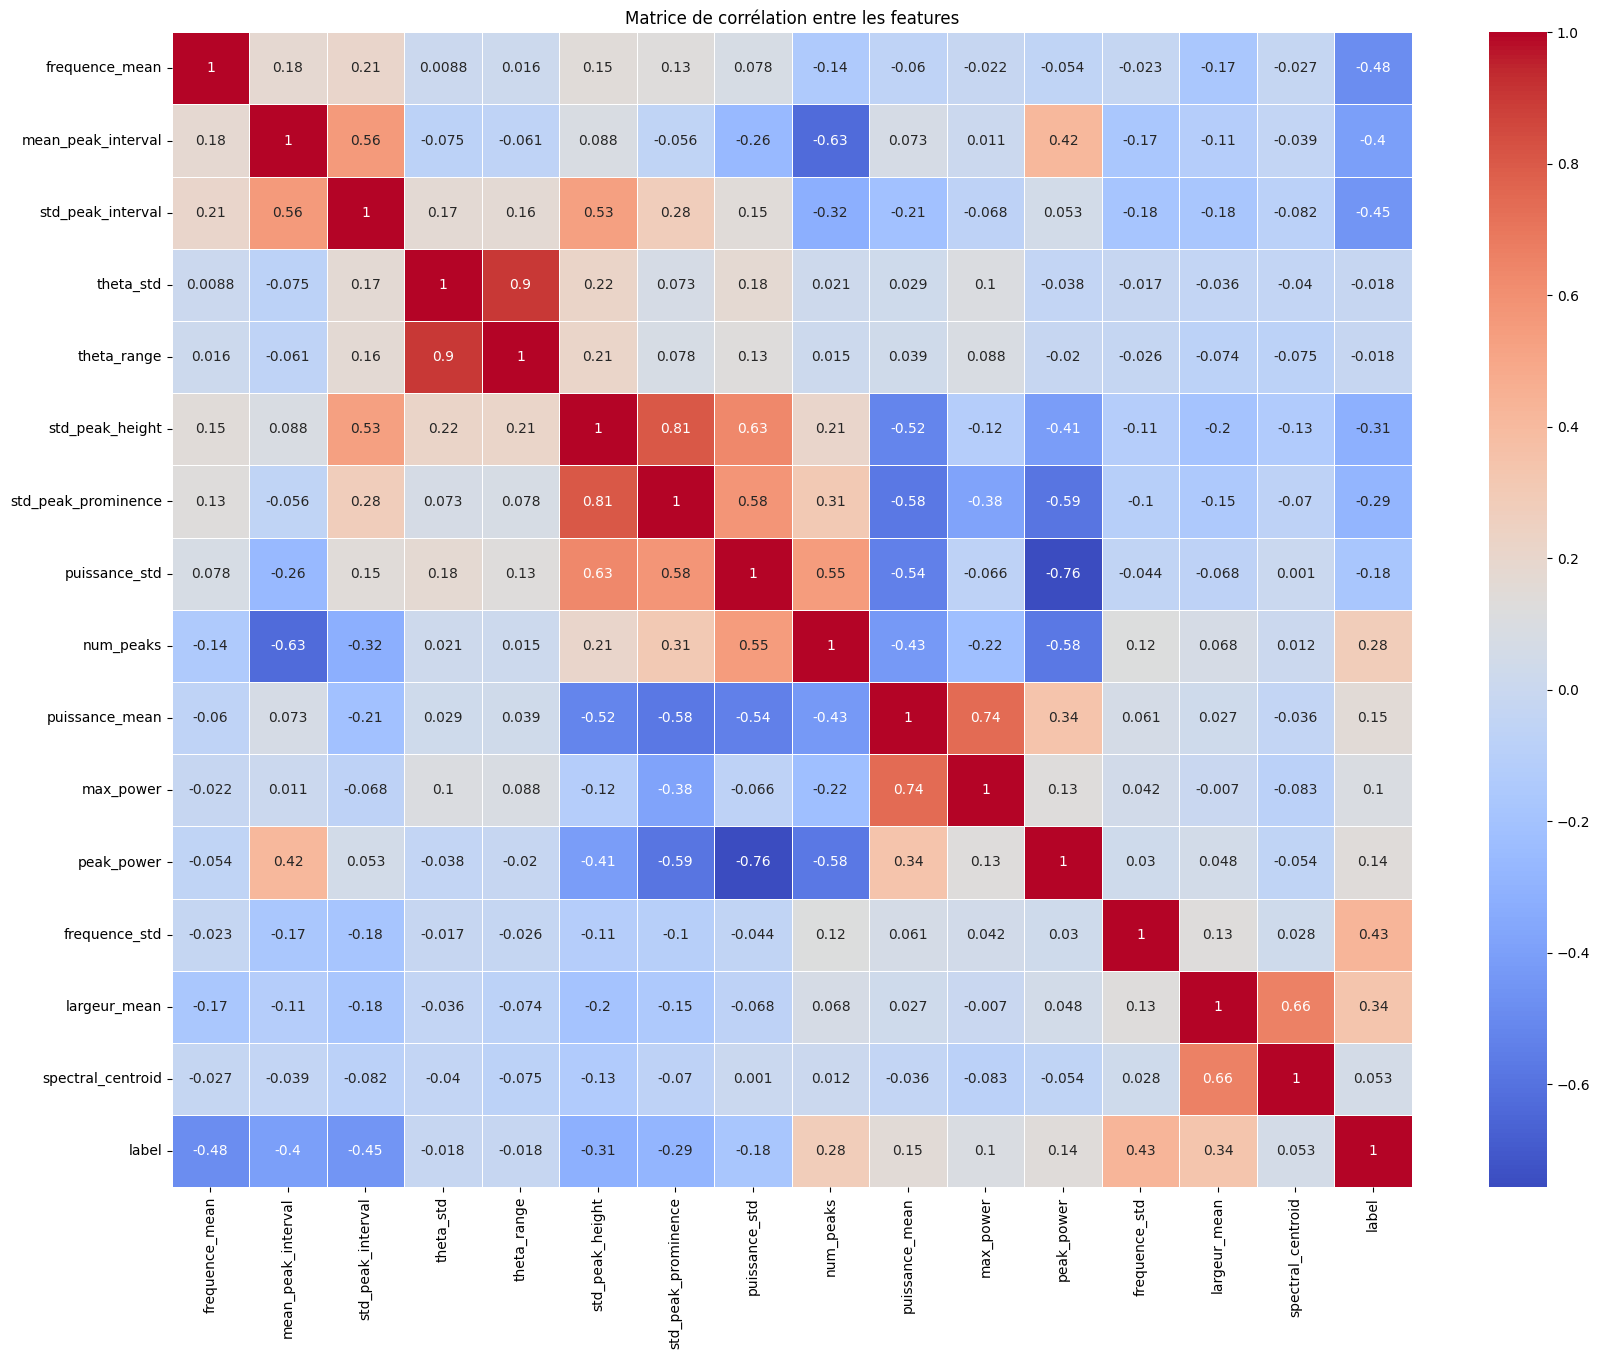

In [42]:
temp_df = pd.concat([selected_features, pd.Series(y_train_full, name='label')], axis=1)
correlation_matrix = temp_df.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title('Matrice de corrélation entre les features')
plt.show()

We see on this final correlation matrix that we removed a lot of multicorrelated features. However, some features are still highly correlated. Sometimes, the wanted information lies inside the small difference of two variables. We can see that theta_range and theta_std are higly correlated (0.9), but we found out that dropping one of them hurt models a lot (~1% accuracy lost). We tried to fuse them with different approaches (substract, divide, use a PCA to extract non linear information), but it suprinsingly did not help the models at all. Thus, we decided to keep them both untouched even though they are highly correlated because it seems that it's in their small variations that the models are able to find valuable informations.

### Sanity check with PCA

To validate our feature selection, we performed a sanity check using Principal Component Analysis (PCA).

Before applying PCA, we centered and standardized all selected features to ensure each contributes equally to the analysis.

We then projected the data onto the first two principal components and examined the most influential features based on their contribution to these components.

In [43]:
all_features_centered = selected_features.to_numpy()

all_features_centered -= all_features_centered.mean(axis=0)
all_features_centered /= all_features_centered.std(axis=0)

pca = PCA(n_components=2).fit(all_features_centered)

In [44]:
# Sort top features from PCA
top_features_for_pca = np.linalg.norm(pca.components_, axis=0).argsort()

for feature_ind in top_features_for_pca:
    msg = f"{selected_features.columns[feature_ind]}: {(pca.components_.T[feature_ind]**2).sum():.3f}"
    print(msg)

frequence_std: 0.038
max_power: 0.046
theta_std: 0.049
frequence_mean: 0.050
spectral_centroid: 0.050
theta_range: 0.052
largeur_mean: 0.089
puissance_mean: 0.145
peak_power: 0.180
puissance_std: 0.182
std_peak_prominence: 0.189
std_peak_height: 0.221
mean_peak_interval: 0.226
num_peaks: 0.236
std_peak_interval: 0.249


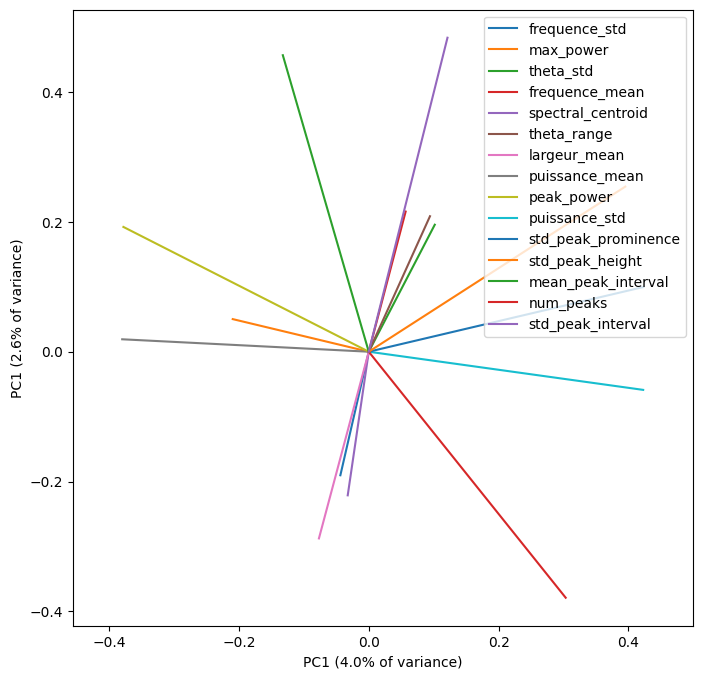

In [45]:
# plot the 2D projection of the features
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("equal")
for feature_ind in top_features_for_pca:  # normaliser par la variance
    dx, dy = pca.components_.T[feature_ind]
    ax.plot([0, dx], [0, dy], label=selected_features.columns[feature_ind])
ax.set_xlabel(f"PC1 ({pca.explained_variance_[0]:.1f}% of variance)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_[1]:.1f}% of variance)")
_ = plt.legend()

The resulting PCA plot shows that our selected features point in different directions, which means that they capture distinct sources of variance in the data.  
Only a few features are closely aligned, thus we should have very low redundant features.
Overall, this confirms that our feature selection preserved most of the valuable information while shrinking redundant features.

## Final Model Training

Now let's try to train our models but on the smaller dataset. Again, we will do some hyperparameters fine tuning with a train and val dataset. Afterwards, we will train our model on the full training set and see how we perform on the test dataset

In [46]:
X_train, X_val, y_train, y_val = train_test_split(selected_features, y_train_full, test_size=0.2, random_state=42)

models_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000,random_state=42),
        "params": {
            "model__C": np.logspace(-3, 2, 10),
            "model__penalty": ["l2"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "model__max_depth": [None, 5, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": np.arange(50, 300, 50),
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": np.arange(3, 20, 2),
            "model__weights": ["uniform", "distance"]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "model__n_estimators": np.arange(50, 300, 50),
            "model__learning_rate": np.logspace(-3, 0, 10),
            "model__max_depth": [2, 3, 4, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
        "params": {
            "model__n_estimators": np.arange(50, 300, 50),
            "model__learning_rate": np.logspace(-3, 0, 10),
            "model__max_depth": [3, 4, 5, 6]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "model__n_estimators": np.arange(50, 300, 50),
            "model__learning_rate": np.logspace(-3, 0, 10)
        }
    }
}


def tune_and_evaluate(models_params, X_train, y_train, X_val, y_val, n_iter=30):
    best_models = {}
    val_scores = []

    for name, config in models_params.items():
        print(f"\n{'='*60}\n Tuning {name}")

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', config['model'])
        ])

        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=config['params'],
            n_iter=n_iter,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        # Evaluate on validation set
        y_pred_val = best_model.predict(X_val)
        acc = accuracy_score(y_val, y_pred_val)
        f1 = f1_score(y_val, y_pred_val, average='weighted')

        val_scores.append({
            'Model': name,
            'Accuracy': acc,
            'F1': f1,
            'Best Params': search.best_params_
        })

        best_models[name] = best_model
        print(f"{name} | Val Accuracy: {acc:.2f}, F1: {f1:.2f}")
        print(f"Best Params: {search.best_params_}")

    return pd.DataFrame(val_scores).sort_values(by='Accuracy', ascending=False), best_models


results_df, best_models = tune_and_evaluate(models_params, X_train, y_train, X_val, y_val)

print("\n\n Validation Results:")
print(results_df)


 Tuning Logistic Regression
Logistic Regression | Val Accuracy: 0.90, F1: 0.90
Best Params: {'model__penalty': 'l2', 'model__C': np.float64(2.1544346900318843)}

 Tuning Decision Tree
Decision Tree | Val Accuracy: 0.88, F1: 0.88
Best Params: {'model__min_samples_split': 10, 'model__max_depth': 10}

 Tuning Random Forest
Random Forest | Val Accuracy: 0.90, F1: 0.90
Best Params: {'model__n_estimators': np.int64(100), 'model__min_samples_split': 2, 'model__max_depth': 20}

 Tuning K-Nearest Neighbors
K-Nearest Neighbors | Val Accuracy: 0.88, F1: 0.88
Best Params: {'model__weights': 'uniform', 'model__n_neighbors': np.int64(11)}

 Tuning Gradient Boosting
Gradient Boosting | Val Accuracy: 0.88, F1: 0.88
Best Params: {'model__n_estimators': np.int64(150), 'model__max_depth': 4, 'model__learning_rate': np.float64(0.1)}

 Tuning XGBoost
XGBoost | Val Accuracy: 0.89, F1: 0.88
Best Params: {'model__n_estimators': np.int64(200), 'model__max_depth': 5, 'model__learning_rate': np.float64(0.021544

In [47]:
print("\n\nRetraining each best model on full training data before testing")

X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

X_test = X_test[X_full_train.columns] # Keep only the selected features

final_models = {}
test_scores = []

for model_name, best_model in best_models.items():
    print(f"\n{'='*60}\nRetraining {model_name} on full training data")

    best_params = results_df.loc[results_df['Model'] == model_name, 'Best Params'].values[0]

    base_model = models_params[model_name]['model']

    final_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', base_model)
    ])

    final_pipe.set_params(**best_params)

    final_pipe.fit(X_full_train, y_full_train)
    final_models[model_name] = final_pipe

    y_pred_test = final_pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average='weighted')

    test_scores.append({
        'Model': model_name,
        'Test Accuracy': acc,
        'Test F1': f1,
    })

test_results = pd.DataFrame(test_scores).sort_values(by='Test Accuracy', ascending=False)

print("\n\nFinal Test Results (after retraining on full train set):")
print(test_results)

best_model_name = test_results.iloc[0]['Model']
print(f"\nBest Performing Model on Test Set: {best_model_name}")




Retraining each best model on full training data before testing

Retraining Logistic Regression on full training data

Retraining Decision Tree on full training data

Retraining Random Forest on full training data

Retraining K-Nearest Neighbors on full training data

Retraining Gradient Boosting on full training data

Retraining XGBoost on full training data

Retraining AdaBoost on full training data


Final Test Results (after retraining on full train set):
                 Model  Test Accuracy   Test F1
2        Random Forest        0.89250  0.892449
4    Gradient Boosting        0.89250  0.892489
5              XGBoost        0.88125  0.881244
6             AdaBoost        0.87750  0.877488
3  K-Nearest Neighbors        0.87125  0.871062
0  Logistic Regression        0.87000  0.869938
1        Decision Tree        0.84375  0.843770

Best Performing Model on Test Set: Random Forest


We managed to get similar performances with our smaller dataset reaching over 0.89 test accuracy thanks to the Gradient Boosting and Random Forest models. We can see that removing a lot of features helped our models understand better the data because they almost all got improved results. However, we can see that both XGBoost and AdaBoost models lost a bit of accuracy with these new features. This might be explained because the models are more sophisticated so it would make sense that they were able to retreive information from more features than the ohter models.

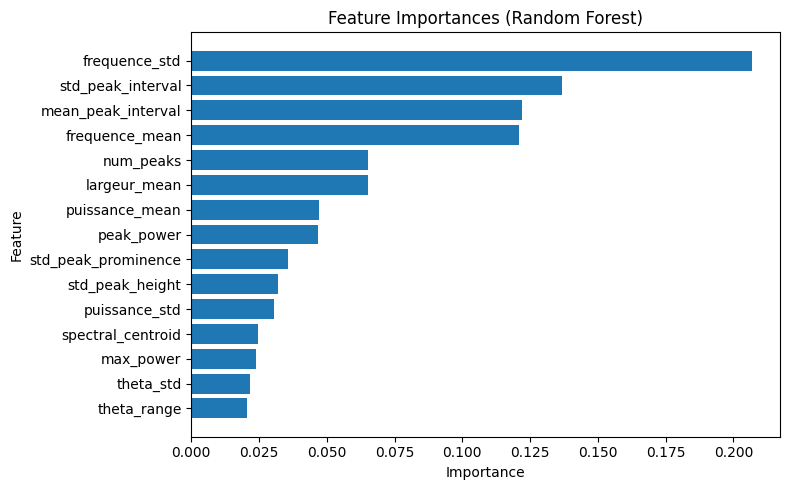

In [48]:
rf_pipe = final_models["Random Forest"]
rf_model = rf_pipe.named_steps["model"]

feature_importances = pd.DataFrame({
    'Feature': X_full_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(
    feature_importances['Feature'][::-1],
    feature_importances['Importance'][::-1]
)
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In this final graph, we can see that for our model, the most important features are :
- frequence_std
- std_peak_interval
- mean_peak_interval
- frequence_mean
- num_peaks

These features are again very consistent with all of our previous analysis. As expected, the frequence plays a crucial role, and we see that the peak analysis (std, mean and num) is also very important.

# Conclusion

In this study, we applied an in-depth analysis of our data in order to create excellent binary classifiers in order to predict or not if a signal is a menace. 

We fisrt did a small eploratory analysis of the data and we saw the the frequency was highly correlated with our target column. Hence, we proposed a first baseline model with a simple frequency threshold and managed to get around 71% accuracy. Then we did a deeper data analysis, we extracted a lot of features in order to train more complexe models. 

After a first round of training and fine tuning, we acheived 89.625 % accuracy with our Adaboost model, increasing by over 18 % our accuracy compared to the baseline model. 

Then, we went into a feature selection pipeline in order to get rid of all the redundant or useless features. We found that just the most important features were related to the frequency, the peak analysis, while other features related to phi or theta where harder to extract valuable information from. Thanks to this analysis we managed to remove over 10 features (going from 25 to 15) while still maintaining an excellent accuracy 89.25 % (on Gradient Boost and Random Forest models). 

We also highlight that even though the best models were Random Forest and Gradient Boosting, we still proposed simpler models (like KNN, Decision Tree or Logistic Regresision) that had great performances (over 88% accuracy for Logistic Regression). Indeed, in the context of a top-secret reconnaissance mission, where any threat must be detected and acted upon in real time, it is crucial to rely on models that combine speed with full interpretability. Pilots generally prefer algorithms such as KNN, Decision Trees, or Logistic Regression, which allow them to understand the reasoning behind each prediction and make rapid, informed decisions. Since no model can ever be 100% accurate, it is essential for the pilot to understand the strengths and weaknesses of the model, using it as an indicator rather than blindly trusting a black box. More sophisticated approaches, like Random Forests or boosting methods (Adaboost, XGBoost), while potentially more accurate, are often slower and less transparent, which can compromise both safety and operational effectiveness in such high-stakes scenarios.